#Labeling an unseen corpus
##Part 0, everything mixed


Lets prepare the data

[link](#shortcut "intra link")

[Wikipedia](https://en.wikipedia.org/wiki/Main_Page "But what is wikipedia?")

Bunch of imports

In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import print_function

# import local library
import tools
import prepare
import lemmatize
import analyze
import preprocess
import nnlstm

##Exctract the MedLine data

In [2]:
data = prepare.extract_txt('data/toy_corpus.txt')

Exctracting from 'toy_corpus'...
224 documents exctracted - 1.9KB  [211.5KB/s]
Done. [0.01s]


##Isolate the abstracts

In [3]:
abstracts = prepare.get_abstracts(data)

Working on 4 core...
1.0KB/s on each of the [4] core
Done. [0.46s]


Cleaning, dumping the abstracts with errors, quick and dirty

In [35]:
def remove_err(datas,errs):
    err=sorted([item for subitem in errs for item in subitem],reverse=True)
    for e in err:
        for d in datas:
            del d[e]

In [36]:
remove_err([abstracts],prepare.get_errors(abstracts))

Replacing numbers with ##NB

In [37]:
abstracts = prepare.filter_numbers(abstracts)

Filtering numbers...
Done. [0.04s]


Creation of a tokenizer for a correct sentence splitting

In [38]:
tokenizer = prepare.create_sentence_tokenizer(abstracts)

Loading sentence tokenizer...
Done. [0.13s]


In [39]:
abstracts_labeled = prepare.ex_all_labels(abstracts,tokenizer)

Working on 4 core...
1.3KB/s on each of the [4] core
Done. [0.40s]


##Lemmatization and special imports

In [40]:
lemmatized = lemmatize.lemm(abstracts_labeled)

Working on 4 core...
Splitting datas... Done. [0.02s]
Lemmatizing...
Done. in 20s]


In [41]:
tools.dump_pickle(lemmatized,"fast_lemmatized.pickle")

File already exist. Overwrite? [Y/N]
>Y
Dumping...
Done. [0.07s]


In [82]:
lemmatized = tools.load_pickle("data/corpus_lemmatized.pickle")

Loading 'data/corpus_lemmatized.pickle'...
Done. [1903.28s]


###Label analysis
*Does not affect the corpus*

In [42]:
dic = analyze.create_dic_simple(lemmatized)

Copying corpus...Done. [0.03s]
Creating dictionary of labels...
Done. [0.00s]


In [44]:
print("Number of labels :",len(dic.keys()))
analyze.show_keys(dic,threshold=10)

Number of labels : 58
195______RESULTS
151______METHODS
146______BACKGROUND
117______CONCLUSIONS
91_______CONCLUSION
26_______INTRODUCTION
22_______OBJECTIVE
16_______MATERIALS AND METHODS
10_______OBJECTIVES
10_______PURPOSE
...
(48 other labels with less than 10 occurences)
...


In [45]:
primary_keyword=['AIM','BACKGROUND','INTRODUCTION','METHOD','RESULT','CONCLUSION','OBJECTIVE','DESIGN','FINDING','OUTCOME','PURPOSE']

In [46]:
analyze.regroup_keys(dic,primary_keyword)

Keys regrouped: 31


In [47]:
analyze.show_keys(dic,threshold=10)

212______CONCLUSION
200______RESULT
192______METHOD
149______BACKGROUND
33_______OBJECTIVE
26_______INTRODUCTION
10_______PURPOSE
...
(22 other labels with less than 10 occurences)
...


In [48]:
keys_to_replace = [['INTRODUCTION','CONTEXT'],
                   ['PURPOSE'],
                  ['AIM','SETTING'],
                  ['RESULT','FINDING','OUTCOME','DISCUSSION']]

replace_with =    ['BACKGROUND',
                   'OBJECTIVE',
                  'METHOD',
                  'CONCLUSION']

In [49]:
analyze.replace_keys(dic,keys_to_replace,replace_with)

Keys regplaced: 9


In [51]:
analyze.show_keys(dic,threshold=10)

392______METHOD
221______CONCLUSION
176______BACKGROUND
54_______OBJECTIVE
...
(16 other labels with less than 10 occurences)
...


###Choosing labels

In [16]:
pattern = [
    ['BACKGROUND','BACKGROUNDS','OBJECTIVE','OBJECTIVES'],
    ['OBJECTIVE','OBJECTIVES','METHOD','METHODS'],
    ['METHOD','METHODS','RESULT','RESULTS'],
    ['RESULT','RESULTS','CONCLUSION','CONCLUSIONS'],
    ['CONCLUSION','CONCLUSIONS']
]

In [17]:
sub_perfect = analyze.get_exactly(lemmatized,pattern=pattern,no_truncate=False)

Selecting abstracts...
1038/2201 match the pattern (47%)
Done. [0.01s]


In [ ]:
sub_perfect = analyze.get_exactly(lemmatized,pattern=pattern,no_truncate=False)

In [18]:
print("%d abstracts labeled and ready for the next part!"%len(sub_perfect))

1038 abstracts labeled and ready for the next part!


##Preparing the data for the classifier

In [83]:
dic = preprocess.create_dic(lemmatized,100)

Copying corpus...Done. [44.05s]
Creating dictionary of labels...
Done. [39.18s]


In [84]:
#primary_keyword=['AIM','BACKGROUND','METHOD','RESULT','CONCLUSION','OBJECTIVE','DESIGN','FINDINGS','OUTCOME','PURPOSE']
analyze.regroup_keys(dic,primary_keyword)

Keys regrouped: 2133


In [85]:
#keys_to_replace = [['INTRODUCTION','BACKGROUND','AIM','PURPOSE','CONTEXT'],
#                  ['CONCLUSION']]

#replace_with =    ['OBJECTIVE',
#                  'RESULT']

analyze.replace_keys(dic,keys_to_replace,replace_with)

Keys regplaced: 9


In [86]:
dic = {key:dic[key] for key in ['BACKGROUND','OBJECTIVE','METHOD','CONCLUSION']}

In [87]:
analyze.show_keys(dic,threshold=10)

947502___METHOD
542346___CONCLUSION
308942___OBJECTIVE
281004___BACKGROUND


In [88]:
print("Sentences per label :",["%s %d"%(s,len(dic[s][1])) for s in dic.keys()])

Sentences per label : ['OBJECTIVE 479326', 'METHOD 3623862', 'BACKGROUND 701814', 'CONCLUSION 1086843']


###Creating train and test data

In [89]:
# classes to use a classifier onto
#classes_names=['BACKGROUND','METHOD','RESULT','CONCLUSION']
classes_names = dic.keys()
dic.keys()

['OBJECTIVE', 'METHOD', 'BACKGROUND', 'CONCLUSION']

Reorder the labels according to your need, for better readability

In [90]:
classes_names = ['BACKGROUND', 'OBJECTIVE', 'METHOD', 'CONCLUSION']

In [91]:
# train/test split
split = 0.8

# truncate the number of abstracts to consider for each label,
# -1 to set to the maximum while keeping the number of sentences per labels equal

raw_x_train, raw_y_train, raw_x_test, raw_y_test = preprocess.split_data(dic,classes_names,
                                                              split_train_test=split,
                                                              truncate=-1)

Vectorizing

In [92]:
X_train, y_train, X_test, y_test, feature_names, max_features, vectorizer = preprocess.vectorize_data(raw_x_train, raw_y_train, raw_x_test, raw_y_test)

Vectorizing the training set...Done. [51.39s]
Getting features...Done. [0.42s]
Creating order...Done. [82.12s]
Done. [133.94s]


In [156]:
%xdel lemmatized
%xdel raw_x_train
%xdel raw_y_train
%xdel raw_x_test
%xdel raw_y_test

NameError: name 'lemmatized' is not defined
NameError: name 'raw_x_train' is not defined
NameError: name 'raw_y_train' is not defined
NameError: name 'raw_x_test' is not defined
NameError: name 'raw_y_test' is not defined


In [93]:
print("Number of features : %d"%(max_features))

Number of features : 180139


##Training a neural network

imports

Adapt the data for a LSTM network

In [94]:
X_train, X_test, y_train, y_test = nnlstm.pad_sequence(X_train, X_test, y_train, y_test, maxlen=100)

Pading sequences...
X_train shape: (1533843, 100)
X_test shape: (383461, 100)
Done. [27.22s]


<a id='shortcut'></a>
shortcut

In [95]:
tools.dump_pickle([X_train, y_train, X_test, y_test, feature_names, max_features, classes_names, vectorizer],"data/training_4_BacObjMetCon.pickle")

Dumping...
Done. [15.81s]


In [159]:
import gc
gc.collect()

702

In [2]:
X_train, y_train, X_test, y_test, feature_names, max_features, classes_names, vectorizer = tools.load_pickle("data/training_4_BacObjMetCon.pickle")

Loading 'data/training_4_BacObjMetCon.pickle'...
Done. [4.96s]


Creating the network

In [3]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Reshape
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM#, JZS1, GRU
from keras.optimizers import Adam, RMSprop

**Need approximatly a minute to construct the network**

In [58]:
%%time
dim_out = len(classes_names)

net = Sequential()
net.add(Embedding(max_features, 16))
net.add(LSTM(16, 16))
net.add(Dense(16, dim_out))
net.add(Dropout(0.5))
net.add(Activation('softmax'))
net.compile(loss='categorical_crossentropy', optimizer='adam', class_mode="categorical")

CPU times: user 52.1 s, sys: 1.7 s, total: 53.8 s
Wall time: 55 s


In [21]:
%%time
dim_out = len(classes_names)

net2 = Sequential()
net2.add(Embedding(max_features, 8))
net2.add(LSTM(8, 8))
net2.add(Dense(8, dim_out))
net2.add(Activation('softmax'))
net2.compile(loss='categorical_crossentropy', optimizer='adam', class_mode="categorical")

CPU times: user 50.1 s, sys: 508 ms, total: 50.6 s
Wall time: 51.7 s


In [101]:
%%time
dim_out = len(classes_names)

net3 = Sequential()
net3.add(Embedding(max_features, 128))
net3.add(LSTM(128, 64))
net3.add(Dropout(0.5))
net3.add(Dense(64, dim_out))
net3.add(Activation('softmax'))
net3.compile(loss='categorical_crossentropy', optimizer='adam', class_mode="categorical")

CPU times: user 1min 1s, sys: 8.52 s, total: 1min 9s
Wall time: 1min 14s


/Library/Python/2.7/site-packages/theano/scan_module/scan_perform_ext.py:133: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  from scan_perform.scan_perform import *


In [24]:
%%time
dim_out = len(classes_names)

net4 = Sequential()
net4.add(Embedding(max_features, 32))
net4.add(JZS1(32, 32))
net4.add(Dropout(0.5))
net4.add(Dense(32, dim_out))
net4.add(Activation('softmax'))
net4.compile(loss='categorical_crossentropy', optimizer='adam', class_mode="categorical")

CPU times: user 30.7 s, sys: 839 ms, total: 31.5 s
Wall time: 31.8 s


In [30]:
%%time
dim_out = len(classes_names)

net5 = Sequential()
net5.add(Embedding(max_features, 32))
net5.add(LSTM(32, 32))
net5.add(Dropout(0.5))
net5.add(Dense(32, dim_out))
net5.add(Activation('softmax'))
net5.compile(loss='categorical_crossentropy', optimizer='adam', class_mode="categorical")

CPU times: user 54.2 s, sys: 574 ms, total: 54.8 s
Wall time: 55.1 s


In [47]:
%%time
dim_out = len(classes_names)

net5 = Sequential()
net5.add(Embedding(max_features, 32))
net5.add(LSTM(32, 32, return_sequences=True))
net5.add(LSTM(32, 32))
net5.add(Dropout(0.5))
net5.add(Dense(32, dim_out))
net5.add(Activation('softmax'))
net5.compile(loss='categorical_crossentropy', optimizer='adam', class_mode="categorical")

#rmsprop = RMSprop(lr=0.002, rho=0.9, epsilon=1e-6)
#adam = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
#batch size = 100
#50 epoch, decay by a 0.95 factor at each epoch after epoch 10
#two layers of LSTM


CPU times: user 2min 6s, sys: 1.56 s, total: 2min 7s
Wall time: 2min 9s


###Training the network

In [6]:
print(len(X_train))
print(len(X_test))

1533843
383461


In [59]:
batch_size=100
b = 300000
b2 = 100000
length_train = 15000
length_test = 5000
nb_epoch = 10
history = train_network(net,
                               X_train[b:b+length_train],
                               y_train[b:b+length_train],
                               X_test[b2:b2+length_test],
                               y_test[b2:b2+length_test],
                               nb_epoch,
                               batch_size=batch_size,
                               path_save="weights",
                               patience=2) # when to apply early stopping if necessary

Training...
Loading 'dirty_ac_stack.pickle'...
Done. [0.04s]
Loading 'dirty_ac_true.pickle'...
Done. [0.09s]
Train on 15000 samples, validate on 5000 samples
Epoch 0
15000/15000 [==============================] - 25s - loss: 1.2393 - acc: 0.3841 - val_loss: 1.0450 - val_acc: 0.5374
Saving at first epoch
Eval ext... Accuracy: 40% [854/2141], RPS: 0.541.   Done [8.46s]
Epoch 1
15000/15000 [==============================] - 23s - loss: 1.0832 - acc: 0.4609 - val_loss: 0.9411 - val_acc: 0.6842
Model improved, saving weight
Eval ext... Accuracy: 47% [1015/2141], RPS: 0.596.   Done [8.22s]
Epoch 2
15000/15000 [==============================] - 24s - loss: 1.0082 - acc: 0.5029 - val_loss: 0.8548 - val_acc: 0.7216
Model improved, saving weight
Eval ext... Accuracy: 54% [1148/2141], RPS: 0.643.   Done [7.96s]
Epoch 3
15000/15000 [==============================] - 24s - loss: 0.9493 - acc: 0.5263 - val_loss: 0.7833 - val_acc: 0.7136
Eval ext... Accuracy: 53% [1141/2141], RPS: 0.640.   Done [7.88

In [69]:
batch_size=100
b = 0
b2 = 0
length_train = 800000
length_test = 10000
nb_epoch = 20
history = train_network(net,
                               X_train[b:b+length_train],
                               y_train[b:b+length_train],
                               X_test[b2:b2+length_test],
                               y_test[b2:b2+length_test],
                               nb_epoch,
                               batch_size=batch_size,
                               path_save="weights",
                               patience=3) # when to apply early stopping if necessary

Training...
Loading 'dirty_ac_stack.pickle'...
Done. [0.04s]
Loading 'dirty_ac_true.pickle'...
Done. [0.10s]
Train on 800000 samples, validate on 10000 samples
Epoch 0
800000/800000 [==============================] - 1411s - loss: 0.8142 - acc: 0.5470 - val_loss: 0.4866 - val_acc: 0.8040
Saving at first epoch
Eval ext... Accuracy: 60% [1275/2141], RPS: 0.688.   Done [8.06s]
Epoch 1
800000/800000 [==============================] - 1863s - loss: 0.7671 - acc: 0.5782 - val_loss: 0.4495 - val_acc: 0.8097
Model improved, saving weight
Eval ext... Accuracy: 61% [1314/2141], RPS: 0.703.   Done [10.51s]
Epoch 2
800000/800000 [==============================] - 1965s - loss: 0.7469 - acc: 0.5883 - val_loss: 0.4398 - val_acc: 0.8111
Model improved, saving weight
Eval ext... Accuracy: 61% [1301/2141], RPS: 0.698.   Done [8.25s]
Epoch 3
800000/800000 [==============================] - 1977s - loss: 0.7317 - acc: 0.5956 - val_loss: 0.4331 - val_acc: 0.8121
Model improved, saving weight
Eval ext... A

KeyboardInterrupt: 

In [25]:
from keras.callbacks import *
class LossKeepIncreasing(Exception):
    pass

def train_network(network,
                  X_train,y_train,X_test,y_test,
                  epoch,
                  batch_size=64,path_save="weights",patience=1):

    t0 = time.time()
    print("Training...")
    sys.stdout.flush()

    if not os.path.exists(path_save):
        os.makedirs(path_save)
         
    ac_stack = tools.load_pickle("dirty_ac_stack.pickle")
    ac_true = tools.load_pickle("dirty_ac_true.pickle")
    
    def _local_evaluate(n_plain_t,n_plain_p):
        c = 0
        for idx,i in enumerate(n_plain_p):
            isit=False
            for idx2,x in enumerate(i):
                if x==1 and x==n_plain_t[idx][idx2]:
                    isit=True
            if isit:
                c+=1
        acc = float(c)/len(n_plain_p)
        rps = metrics.label_ranking_average_precision_score(n_plain_t,n_plain_p)
        print("\x1b[33mAccuracy: %.02f%%\x1b[0m [%d/%d], \x1b[33mRPS: %.03f\x1b[0m"%(acc*100,c,len(n_plain_p),
                                        rps),end="")
        return acc,rps

    class LossHistory(Callback):
        def on_train_begin(self, logs={}):
            self.losses = []
            self.accuracy = []
            self.val_losses = []
            self.val_accuracy = []
            self.ext_accuracy = []
            self.ext_rps = []
            self.metric = []
            self.file_name = []
            self.pos = 0

        def on_batch_end(self, batch, logs={}):
            self.losses.append(logs.get('loss'))
            self.accuracy.append(logs.get('acc'))

        def on_epoch_end(self, epoch, logs={}):
            try:
                self.val_losses.append(logs.get('val_loss'))
                self.val_accuracy.append(logs.get('val_acc'))
                self.metric.append(self.val_accuracy[-1]-(self.val_losses[-1]/10.))
                if len(self.val_accuracy)<2:
                    #network.save_weights("weights/weight_%d.hdf5"%self.pos,overwrite=True)
                    print("\x1b[35mSaving at first epoch\x1b[0m")
                else:
                    tmp = True
                    for i in self.metric[:-1]:
                        if self.metric[-1]<i:
                            tmp = False
                            break
                    if tmp:
                        network.save_weights("%s/best.hdf5"%path_save,overwrite=True)
                        print("\x1b[35mModel improved, saving weight\x1b[0m")
                network.save_weights("%s/epoch_%d.hdf5"%(path_save,self.pos),overwrite=True)

                #evaluate on other corpus
                tx = time.time()
                print("Eval ext... ",end="")
                sys.stdout.flush()
                nn_pred = LSTMPredictor(network,vectorizer,classes_names)
                pred_label=[]
                for idx,x in enumerate(ac_stack):
                    pred_label.append(nn_pred.silence_predict_on_csv(x))
                    tmp = []
                ac_pred_label = []
                for i in pred_label:
                    for j in i:
                        ac_pred_label.append(j)
                acc,rps = _local_evaluate(ac_true,ac_pred_label)
                self.ext_accuracy.append(acc)
                self.ext_rps.append(rps)
                print(".   Done [%.02fs]"%(time.time()-tx))

                self.pos=self.pos+1

                cpt = 0
                if len(self.val_accuracy)>1:
                    for i in self.metric[-(patience+1):-1]:
                        if self.metric[-1]<i:
                            cpt += 1
                if patience == cpt:
                    raise LossKeepIncreasing
            except:
                e = sys.exc_info()[0]
                print("Couldn't log, re-trying. Error: %s"%e)
                try:
                    network.save_weights("%s/epoch_%d.hdf5"%(path_save,self.pos),overwrite=True)
                    self.pos=self.pos+1
                except:
                    e = sys.exc_info()[0]
                    print("Hum... Couldn't save nether. Error: %s"%e)

    history = LossHistory()

    try:
        network.fit(X_train, y_train, batch_size=batch_size, nb_epoch=epoch,
                    validation_data=(X_test, y_test), show_accuracy=True, callbacks=[history])#,earlystop])
    except LossKeepIncreasing:
        print("Accuracy keep decreasing, stopping early.")
    #network.load_weights("%s/best.hdf5"%path_save)
    print("Done. [%.02fs]"%(time.time()-t0))
    return history

In [106]:
#net.load_weights("weights/epoch_6.hdf5")
#net.load_weights("weights/best.hdf5")

net.save_weights("weights/val_062_16_16-16_16_800000.hdf5")
#net.save_weights("weights/best_090_16_16-16_16_800000.hdf5")
#net.load_weights("weights/epoch_6.hdf5")

##Evaluate the network

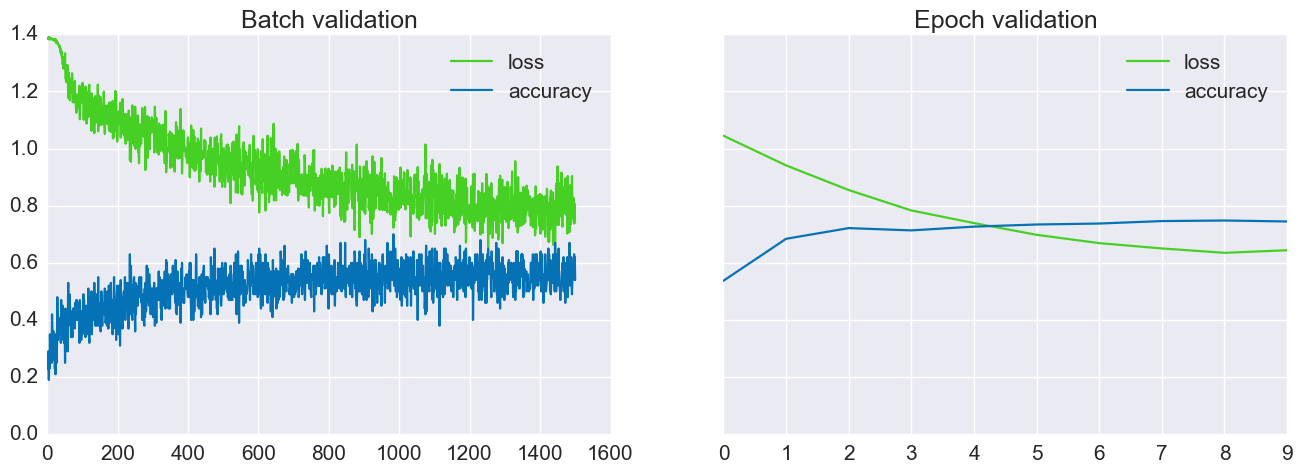

In [61]:
#enought data, dropout more!
nnlstm.show_history(history)

No decision: 0 / 383460  [0.00%]0 0
Accuracy: 0.901869
             precision    recall  f1-score   support

 BACKGROUND       0.74      0.66      0.70    108779
  OBJECTIVE       0.59      0.71      0.64     80227
     METHOD       0.93      0.90      0.91     98710
 CONCLUSION       0.99      0.99      0.99     95744

avg / total       0.82      0.81      0.81    383460

Confusion matrix:
[[71415 33954  3225   185]
 [20447 56586  3063   131]
 [ 4187  5070 88955   498]
 [   60   515   604 94565]]


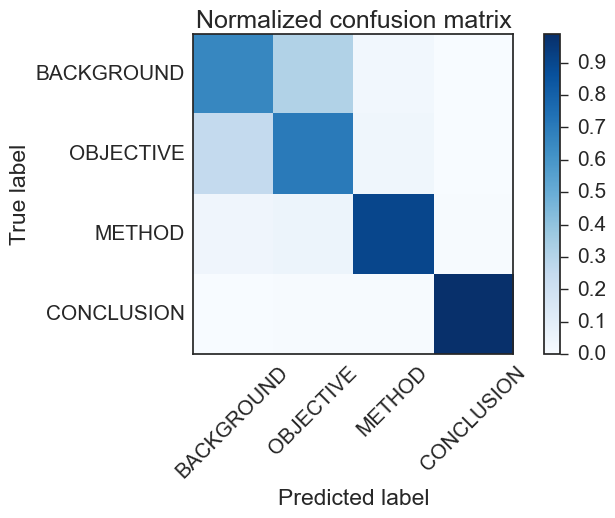

In [105]:
nnlstm.evaluate_network(net, X_test, y_test, classes_names, length=-1)

No decision: 0 / 5000  [0.00%]0 0
Accuracy: 0.897933
             precision    recall  f1-score   support

 BACKGROUND       0.64      0.68      0.66      1183
  OBJECTIVE       0.65      0.66      0.66      1253
     METHOD       0.94      0.88      0.91      1314
 CONCLUSION       0.99      0.99      0.99      1250

avg / total       0.81      0.81      0.81      5000

Confusion matrix:
[[ 799  354   28    2]
 [ 382  827   39    5]
 [  64   78 1161   11]
 [   1    5    2 1242]]


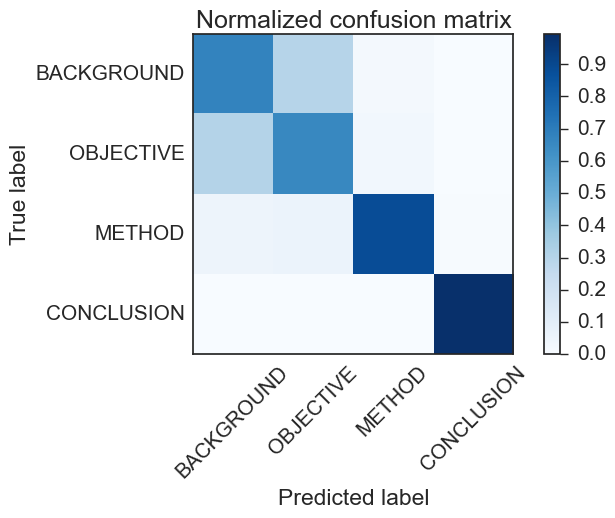

In [113]:
#net.load_weights('weights/best.hdf5')
nnlstm.evaluate_network(net, X_test, y_test, classes_names, length=length_test)

##Predict on a new corpus

In [107]:
predictor = nnlstm.LSTMPredictor(net3,vectorizer,classes_names,len_graph=20)

In [108]:
tokenizer = tools.load_pickle("data/tokenizer.pickle")

Loading 'data/tokenizer.pickle'...
Done. [0.12s]


In [636]:
import random

In [639]:
rc =  random.choice(lemmatized)
for i in rc:
    for j in classes_names:
        if i[0].rfind(j) != -1:
            i[0] = j
predictor.predict_labeled(rc)

to detect the occurrence of low susceptibility to colistin ( polymyxin e ) a last-resort antimicrobial among enterobacteria isolate from sample of animal origin ( poultry and swine ) and to find out the molecular basis of colistin resistance

BACKGROUND |0.213|****
OBJECTIVE  |0.782|**************** [true label][predicted label]
METHOD     |0.003|
RESULT     |0.001|
CONCLUSION |0.001|
________________________________________________________________________________

salmonella enterica and escherichia coli be isolate from egg and swine sample

BACKGROUND |0.351|*******
OBJECTIVE  |0.595|************ [predicted label]
METHOD     |0.046|* [true label]
RESULT     |0.004|
CONCLUSION |0.004|
________________________________________________________________________________

bacterial strain be screen for colistin resistance by use mic determination interpret accord to eucast recommendation

BACKGROUND |0.477|********** [predicted label]
OBJECTIVE  |0.263|*****
METHOD     |0.187|**** [true labe

---

---

---

In [52]:
model_list = tools.exctract_models()

Model ready: rf
Model ready: svc


In [53]:
models = tools.load_models()#models=models)

. models/rf
├── Loading classifier 'rf'...
├── Done. [3.54s]
├── Loading vectorizer 'rf'...
└── Done. [17.14s]
. models/svc
├── Loading classifier 'svc'...
├── Done. [0.12s]
├── Loading vectorizer 'svc'...
└── Done. [53.36s]


In [134]:
class RFPredictor:

    def __init__(self,network,vectorizer,classes_names,nb_index=100,len_graph=20):
        self.tagger = Blobber(pos_tagger=PerceptronTagger())
        self.classes_names = classes_names
        self.vect = vectorizer
        self.network = network
        d = {}
        _color=[1,2,3,5,6,7]
        for idx,i in enumerate(classes_names):
            d[i]=_color[idx%len(_color)]
        self.colors = d
        self.nb_index = nb_index
        self.len_graph = len_graph
        Word("test")

    def _draw_pred(self,predicted,true_label,proba):
        m_len = np.array([len(i) for i in self.classes_names]).max()
        for idx,i in enumerate(self.classes_names):
            s = i.ljust(m_len+1)
            p = proba[idx]
            pad = '*'*int(round(p*self.len_graph))
            if len(pad)>(self.len_graph*2):
                pad='*'*(self.len_graph*2)
            if self.classes_names[idx] == predicted == true_label:
                print("\x1b[42m%s\x1b[0m|\x1b[37m%.03f\x1b[0m|%s \x1b[32m[true label][predicted label]\x1b[0m"%(s,p,pad))
            elif self.classes_names[idx] == predicted:
                print("\x1b[45m%s\x1b[0m|\x1b[37m%.03f\x1b[0m|%s \x1b[35m[predicted label]\x1b[0m"%(s,p,pad))
            elif self.classes_names[idx] == true_label:
                print("\x1b[43m%s\x1b[0m|\x1b[37m%.03f\x1b[0m|%s \x1b[33m[true label]\x1b[0m"%(s,p,pad))
            else:
                print("%s|\x1b[37m%.03f\x1b[0m|\x1b[37m%s\x1b[0m"%(s,p,pad))

    def get_prediction(self,text,true_label):
        corr = self.classes_names
        tt = self.vect.transform([text])

        a = self.network.predict_proba(tt)
        c = a.max()

        self._draw_pred(self.classes_names[a.argmax()],true_label,a[0])
        return c,corr[a.argmax()]

    def predict_labeled(self,lab):
        cc=0
        d=self.colors
        for i in lab:
            cpt=0.0
            for x in lab:
                cpt+=len(x[1])
            tmp=[]
            for smt in i[1]:
                tmp.append("##IDX%s %s"%(str(int((cc/cpt)*self.nb_index)),smt))
                cc+=1
            for j in tmp:
                print("%s\n"%(j[7:]))
                confidence,predd = self.get_prediction(j,i[0])
                print('_'*80)
                print()

In [144]:
class SVCPredictor:

    def __init__(self,network,vectorizer,classes_names,nb_index=100,len_graph=20):
        self.tagger = Blobber(pos_tagger=PerceptronTagger())
        self.classes_names = classes_names
        self.vect = vectorizer
        self.network = network
        d = {}
        _color=[1,2,3,5,6,7]
        for idx,i in enumerate(classes_names):
            d[i]=_color[idx%len(_color)]
        self.colors = d
        self.nb_index = nb_index
        self.len_graph = len_graph
        Word("test")

    def _draw_pred(self,predicted,true_label,proba):
        m_len = np.array([len(i) for i in self.classes_names]).max()
        for idx,i in enumerate(self.classes_names):
            s = i.ljust(m_len+1)
            p = proba[idx]
            pad = '*'*int(round(p*self.len_graph))
            if len(pad)>(self.len_graph*2):
                pad='*'*(self.len_graph*2)
            if self.classes_names[idx] == predicted == true_label:
                print("\x1b[42m%s\x1b[0m|\x1b[37m%.03f\x1b[0m|%s \x1b[32m[true label][predicted label]\x1b[0m"%(s,p,pad))
            elif self.classes_names[idx] == predicted:
                print("\x1b[45m%s\x1b[0m|\x1b[37m%.03f\x1b[0m|%s \x1b[35m[predicted label]\x1b[0m"%(s,p,pad))
            elif self.classes_names[idx] == true_label:
                print("\x1b[43m%s\x1b[0m|\x1b[37m%.03f\x1b[0m|%s \x1b[33m[true label]\x1b[0m"%(s,p,pad))
            else:
                print("%s|\x1b[37m%.03f\x1b[0m|\x1b[37m%s\x1b[0m"%(s,p,pad))
                
    def _except_draw_pred(self,predicted,true_label):
        m_len = np.array([len(i) for i in self.classes_names]).max()
        for idx,i in enumerate(self.classes_names):
            s = i.ljust(m_len+1)
            if self.classes_names[idx] == predicted == true_label:
                print("\x1b[42m%s\x1b[0m| \x1b[32m[true label][predicted label]\x1b[0m"%(s))
            elif self.classes_names[idx] == predicted:
                print("\x1b[45m%s\x1b[0m| \x1b[35m[predicted label]\x1b[0m"%(s))
            elif self.classes_names[idx] == true_label:
                print("\x1b[43m%s\x1b[0m| \x1b[33m[true label]\x1b[0m"%(s))
            else:
                print("%s|"%(s))

    def get_prediction(self,text,true_label):
        corr = self.classes_names
        tt = self.vect.transform([text])

        a = self.network.decision_function(tt)
        c = a.max()-a.mean()

        self._draw_pred(self.classes_names[a.argmax()],true_label,a[0])
        return c,corr[a.argmax()]

    def predict_labeled(self,lab):
        cc=0
        d=self.colors
        for i in lab:
            cpt=0.0
            for x in lab:
                cpt+=len(x[1])
            tmp=[]
            for smt in i[1]:
                tmp.append("##IDX%s %s"%(str(int((cc/cpt)*self.nb_index)),smt))
                cc+=1
            for j in tmp:
                print("%s\n"%(j[7:]))
                confidence,predd = self.get_prediction(j,i[0])
                print('_'*80)
                print()

In [153]:
class oth_Predictor:

    def __init__(self,network,vectorizer,classes_names,nb_index=100,len_graph=20):
        self.tagger = Blobber(pos_tagger=PerceptronTagger())
        self.classes_names = classes_names
        self.vect = vectorizer
        self.network = network
        d = {}
        _color=[1,2,3,5,6,7]
        for idx,i in enumerate(classes_names):
            d[i]=_color[idx%len(_color)]
        self.colors = d
        self.nb_index = nb_index
        self.len_graph = len_graph
        Word("test")

    def _draw_pred(self,predicted,true_label):
        m_len = np.array([len(i) for i in self.classes_names]).max()
        for idx,i in enumerate(self.classes_names):
            s = i.ljust(m_len+1)
            if self.classes_names[idx] == predicted == true_label:
                print("\x1b[42m%s\x1b[0m| \x1b[32m[true label][predicted label]\x1b[0m"%(s))
            elif self.classes_names[idx] == predicted:
                print("\x1b[45m%s\x1b[0m| \x1b[35m[predicted label]\x1b[0m"%(s))
            elif self.classes_names[idx] == true_label:
                print("\x1b[43m%s\x1b[0m| \x1b[33m[true label]\x1b[0m"%(s))
            else:
                print("%s|"%(s))

    def get_prediction(self,text,true_label):
        tt = self.vect.transform([text])

        self._draw_pred(self.classes_names[self.network.predict(tt)[0]] , true_label)
        return 0, self.classes_names[self.network.predict(tt)[0]]


    def predict_labeled(self,lab):
        cc=0
        d=self.colors
        for i in lab:
            cpt=0.0
            for x in lab:
                cpt+=len(x[1])
            tmp=[]
            for smt in i[1]:
                tmp.append("##IDX%s %s"%(str(int((cc/cpt)*self.nb_index)),smt))
                cc+=1
            for j in tmp:
                print("%s\n"%(j[7:]))
                confidence,predd = self.get_prediction(j,i[0])
                print('_'*80)
                print()

In [13]:
tknz = tools.load_pickle("data/tokenizer.pickle")

Loading 'data/tokenizer.pickle'...
Done. [0.11s]


In [106]:
out = nnlstm.get_oth_lab(oold("d6"),tokenizer)

In [23]:
from textblob import Blobber
from textblob_aptagger import PerceptronTagger
from textblob import Word

In [158]:
net_pred = nnlstm.LSTMPredictor(net,vectorizer,classes_names,len_graph=20)

rf_pred = RFPredictor(models["clf_rf"],models["vectorizer_rf"],classes_names,nb_index=10,len_graph=20)
svc_pred = SVCPredictor(models["clf_svc"],models["vectorizer_svc"],classes_names,nb_index=10,len_graph=20)
rb_pred = oth_Predictor(models["clf_bn"],models["vectorizer_bn"],classes_names,nb_index=10,len_graph=20)
sgd_pred = oth_Predictor(models["clf_sgd"],models["vectorizer_sgd"],classes_names,nb_index=10,len_graph=20)

In [334]:
%%time
net_pred.predict_labeled(out)

In this study we investigate the merits of fast approximate string matching to address challenges relating to spelling variants and to utilise large-scale lexical resources for semantic class disambiguation. 

BACKGROUND |0.982|******************** [true label][predicted label]
METHOD     |0.008|
RESULT     |0.002|
CONCLUSION |0.008|
________________________________________________________________________________

We integrate string matching results into machine learning-based disambiguation through the use of a novel set of features that represent the distance of a given textual span to the closest match in each of a collection of lexical resources.

BACKGROUND |0.985|******************** [predicted label]
METHOD     |0.005| [true label]
RESULT     |0.002|
CONCLUSION |0.008|
________________________________________________________________________________

We collect lexical resources for a multitude of semantic categories from a variety of biomedical domain sources.

BACKGROUND |0.28

In [161]:
%%time
rf_pred.predict_labeled(out)

In this study we investigate the merits of fast approximate string matching to address challenges relating to spelling variants and to utilise large-scale lexical resources for semantic class disambiguation. 

BACKGROUND |0.980|******************** [true label][predicted label]
METHOD     |0.020|
RESULT     |0.000|
CONCLUSION |0.000|
________________________________________________________________________________

We integrate string matching results into machine learning-based disambiguation through the use of a novel set of features that represent the distance of a given textual span to the closest match in each of a collection of lexical resources.

BACKGROUND |0.940|******************* [predicted label]
METHOD     |0.040|* [true label]
RESULT     |0.000|
CONCLUSION |0.020|
________________________________________________________________________________

We collect lexical resources for a multitude of semantic categories from a variety of biomedical domain sources.

BACKGROUND |0.14

In [162]:
%%time
svc_pred.predict_labeled(out)

In this study we investigate the merits of fast approximate string matching to address challenges relating to spelling variants and to utilise large-scale lexical resources for semantic class disambiguation. 

BACKGROUND |1.466|***************************** [true label][predicted label]
METHOD     |-1.209|
RESULT     |-2.084|
CONCLUSION |-2.797|
________________________________________________________________________________

We integrate string matching results into machine learning-based disambiguation through the use of a novel set of features that represent the distance of a given textual span to the closest match in each of a collection of lexical resources.

BACKGROUND |-0.303|
METHOD     |0.680|************** [true label][predicted label]
RESULT     |-1.775|
CONCLUSION |-1.833|
________________________________________________________________________________

We collect lexical resources for a multitude of semantic categories from a variety of biomedical domain sources.

BACKGROU

In [163]:
%%time
rb_pred.predict_labeled(out)

In this study we investigate the merits of fast approximate string matching to address challenges relating to spelling variants and to utilise large-scale lexical resources for semantic class disambiguation. 

BACKGROUND | [true label][predicted label]
METHOD     |
RESULT     |
CONCLUSION |
________________________________________________________________________________

We integrate string matching results into machine learning-based disambiguation through the use of a novel set of features that represent the distance of a given textual span to the closest match in each of a collection of lexical resources.

BACKGROUND |
METHOD     | [true label][predicted label]
RESULT     |
CONCLUSION |
________________________________________________________________________________

We collect lexical resources for a multitude of semantic categories from a variety of biomedical domain sources.

BACKGROUND |
METHOD     | [true label][predicted label]
RESULT     |
CONCLUSION |
_______________________

In [164]:
%%time
sgd_pred.predict_labeled(out)

In this study we investigate the merits of fast approximate string matching to address challenges relating to spelling variants and to utilise large-scale lexical resources for semantic class disambiguation. 

BACKGROUND | [true label]
METHOD     | [predicted label]
RESULT     |
CONCLUSION |
________________________________________________________________________________

We integrate string matching results into machine learning-based disambiguation through the use of a novel set of features that represent the distance of a given textual span to the closest match in each of a collection of lexical resources.

BACKGROUND |
METHOD     | [true label][predicted label]
RESULT     |
CONCLUSION |
________________________________________________________________________________

We collect lexical resources for a multitude of semantic categories from a variety of biomedical domain sources.

BACKGROUND |
METHOD     | [true label][predicted label]
RESULT     |
CONCLUSION |
______________________

---

---

---

In [74]:
import pandas as pd
import sys
from IPython.display import clear_output

from os import listdir
from os.path import isfile, join

In [75]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import matplotlib.pyplot as plt

from textblob import Blobber
from textblob_aptagger import PerceptronTagger
from textblob import Word

import numpy as np
import sys
import codecs
import re
import multiprocessing
import pickle
import copy
import time
import random
import os

import seaborn as sns

In [76]:
class LSTMPredictor:
    def __init__(self,network,vectorizer,classes_names,nb_index=100,len_graph=20):
        self.tagger = Blobber(pos_tagger=PerceptronTagger())
        self.classes_names = classes_names
        self.vect = vectorizer
        self.network = network
        self.nb_index = nb_index
        self.len_graph = len_graph
        
    def _vect_label(self,n):
        tmp = np.zeros(len(self.classes_names))
        tmp[n] = 1
        return tmp
    
    def silence_get_prediction(self,sent):
        tag = self.tagger(sent[24:].encode("utf8").lower()).tags
        ph_out=[]
        for i in tag:
            if i[1][0]=='V':
                ph_out.append(Word(i[0]).lemmatize('v'))
            elif i[1][0]=='N':
                ph_out.append(Word(i[0]).lemmatize('n'))
            else:
                ph_out.append(i[0])
        find = r'[0-9]+\.[0-9]+|[0-9]+,[0-9]+|[0-9]+'
        res = re.sub(find,r'##NB'," ".join(ph_out))
        ph_out=res.split()
        l = [sent[0:7].lower(),sent[8:15].lower(),sent[16:23].lower()]
        l.extend(ph_out)
        x = []
        for i in l:
            try:
                x.append(self.vect.vocabulary_[i])
            except KeyError:
                pass
        x = np.array([x])

        tmp=self.network.predict_classes(x, batch_size=32,verbose=False)[0]
        tmp2=self.network.predict_proba(x, batch_size=32,verbose=False)[0]
        am= np.array(tmp2).argmax()
        return 0,self._vect_label(am)
            
    def silence_predict_on_csv(self,lab):
        cc=0.0
        cpt=len(lab)
        out = []
        for i in lab:
            tmp = "##LEN%02d ##POS%02d ##IDX%02d %s"%(cpt,cc,int((cc/cpt)*self.nb_index),i[1]) 
            cc+=1
            confidence,predd = self.silence_get_prediction(tmp)
            out.append(predd)
        return out#,out_true         

In [77]:
class RFPredictor:

    def __init__(self,network,vectorizer,classes_names,nb_index=10,len_graph=20):
        self.tagger = Blobber(pos_tagger=PerceptronTagger())
        self.classes_names = classes_names
        self.vect = vectorizer
        self.network = network
        self.nb_index = nb_index
        self.len_graph = len_graph
        
    def _vect_label(self,n):
        tmp = np.zeros(len(self.classes_names))
        tmp[n] = 1
        return tmp
    
    def silence_get_prediction(self,text):
        corr = self.classes_names
        tt = self.vect.transform([text])

        a = self.network.predict_proba(tt)
        c = a.max()
        return 0,self._vect_label(a.argmax())
            
    def silence_predict_on_csv(self,lab):
        cc=0.0
        cpt=len(lab)
        out = []
        for i in lab:
            tmp = "##IDX%s %s"%(str(int((cc/cpt)*self.nb_index)),i[1])
            cc+=1
            confidence,predd = self.silence_get_prediction(tmp)
            out.append(predd)
        return out#,out_true

In [78]:
class SVCPredictor:

    def __init__(self,network,vectorizer,classes_names,nb_index=10,len_graph=20):
        self.tagger = Blobber(pos_tagger=PerceptronTagger())
        self.classes_names = classes_names
        self.vect = vectorizer
        self.network = network
        self.nb_index = nb_index
        self.len_graph = len_graph
        
    def _vect_label(self,n):
        tmp = np.zeros(len(self.classes_names))
        tmp[n] = 1
        return tmp
    
    def silence_get_prediction(self,text):
        corr = self.classes_names
        tt = self.vect.transform([text])

        a = self.network.decision_function(tt)
        c = a.max()-a.mean()
        return 0,self._vect_label(a.argmax())
            
    def silence_predict_on_csv(self,lab):
        cc=0.0
        cpt=len(lab)
        out = []
        for i in lab:
            tmp = "##IDX%s %s"%(str(int((cc/cpt)*self.nb_index)),i[1])
            cc+=1
            confidence,predd = self.silence_get_prediction(tmp)
            out.append(predd)
        return out#,out_true

In [107]:
def evaluate_on_annotated(f_name,predictor,mapping_prediction,mapping_true):
    df = pd.read_csv(f_name,sep=';')
    df.columns = ["Number","Type","BACKGROUND","OBJECTIVE","METHOD","RESULT","Sentences"]

    sentences=[]
    stack = [[]]
    classes_names_doc = ["BACKGROUND","OBJECTIVE","METHOD","RESULT"]
    for i, [index, row] in enumerate(df.iterrows()):
        if row["Number"]==row["Number"]:
            if row["Type"]=="File name":
                stack.append([])
            elif row["Type"]=="Title":
                pass
            else:
                labels = []
                for i in classes_names_doc:
                    x = row[i]
                    if x == x:
                        labels.append(i)
                if len(labels)>0:
                    stack[-1].append([labels,row["Sentences"]])
    del(stack[0])

    def vect_label(n,nb):
        tmp = np.zeros(nb)
        tmp[n] = 1
        return tmp

    tmp_dic = {"BACKGROUND":0,"OBJECTIVE":1,"METHOD":2,"RESULT":3}

    pred_label=[]
    true_label=[]
    skipped=0
    for x in stack:
        try:
            pred_label.append(predictor.silence_predict_on_csv(x))
            tmp = []
            for j in x:
                tmp.append(vect_label([ tmp_dic[i] for i in j[0] ], 4))
            true_label.append(tmp)
        except:
            skipped+=1
            pass
    #print("Abstracts with errors : %d"%(skipped))

    plain_t=[]
    plain_p=[]
    for i in true_label:
        for j in i:
            plain_t.append(j)
    for i in pred_label:
        for j in i:
            plain_p.append(j)

    ####        
    map_from = mapping_prediction[0]
    map_to   = mapping_prediction[1]
    d = {}
    c=0
    for idx,i in enumerate(map_from):
        for idx2,j in enumerate(i):
            d[c]=idx
            c+=1

    map_from = mapping_true[0]
    map_to   = mapping_true[1]
    d2 = {}
    c=0
    for idx,i in enumerate(map_from):
        for idx2,j in enumerate(i):
            d2[c]=idx
            c+=1

    ####    
    n_plain_p=[]
    for i in plain_p:
        tmp = np.zeros(len(map_to))
        for idx, i in enumerate(i):
            if i!=0:
                tmp[d[idx]] = 1
        n_plain_p.append(tmp)
    n_plain_t=[]
    for i in plain_t:
        tmp = np.zeros(len(map_to))
        for idx, i in enumerate(i):
            if i!=0:
                tmp[d2[idx]] = 1
        n_plain_t.append(tmp)

    cpt = 0
    for idx,i in enumerate(n_plain_p):
        isit=False
        for idx2,x in enumerate(i):
            if x==1 and x==n_plain_t[idx][idx2]:
                isit=True
        if isit:
            cpt+=1
    print("Accuracy : %.f%% [%d/%d]"%((float(cpt)/len(n_plain_p))*100,cpt,len(n_plain_p)))
        
    #_local_evaluate(n_plain_t,n_plain_p)
    return n_plain_t, n_plain_p, stack

In [92]:
def _local_evaluate(n_plain_t,n_plain_p):
    a1=[]
    a2=[]
    cpt=0
    cpt_on=[]
    cpt_real=[]
    
    #print("Accuracy : %.f%% [%d/%d]"%((float(cpt)/len(n_plain_p))*100,cpt,len(n_plain_p)))

    for idx, i in enumerate(n_plain_p):
        a1.append(np.array(i).argmax())
        a2.append(np.array(n_plain_t[idx]).argmax())

    # for info on this score, cf:
    # http://scikit-learn.org/stable/modules/generated/sklearn.metrics.label_ranking_average_precision_score.html
    print("Ranked precision score: %.06f"%metrics.label_ranking_average_precision_score(n_plain_t,n_plain_p))

    cpt_on = np.array(cpt_on)
    print(metrics.classification_report(a2,a1,target_names=map_to))

    print("Confusion matrix:")
    cm = confusion_matrix(a2, a1)
    print(cm)
    sns.set_style("ticks")
    sns.mpl.rc("figure", figsize=(8,4))

    np.set_printoptions(precision=2)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig = plt.figure()
    plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Normalized confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(map_to))
    plt.xticks(tick_marks, map_to, rotation=45)
    plt.yticks(tick_marks, map_to)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tick_params(which='both', direction='in',length=0)
    plt.show()

In [81]:
skipped=0
pred_label=[]
l=[]
for idx,x in enumerate(ac_stack):
    try:
        pred_label.append(nn_pred.silence_predict_on_csv(x))
        tmp = []
        #for j in x:
        #    tmp.append(vect_label([ tmp_dic[i] for i in j[0] ], 4))
        #true_label.append(tmp)
    except:
        l.append(idx)
        skipped+=1
        pass

NameError: name 'ac_stack' is not defined

In [187]:
#for i in l[::-1]:
#    del ac_stack[i]


In [188]:
print(len(ac_stack))
print(skipped)

521
19


In [190]:
tools.dump_pickle(ac_stack,"dirty_ac_stack")

File already exist. Overwrite? [Y/N]
>Y
Dumping...
Done. [0.08s]


In [176]:
tools.dump_pickle(ac_true,"dirty_ac_true")

Dumping...
Done. [0.17s]


In [162]:
pred_label[0]

[array([ 1.,  0.,  0.,  0.]), array([ 0.,  0.,  1.,  0.])]

In [182]:
path = './annotations/csv/'
onlyfiles = [ f for f in listdir(path) if isfile(join(path,f)) ]
t_ac_true = []
t_ac_pred = []
t_ac_stack = []
for i in onlyfiles:
    if not i.startswith('.') and not i.startswith('_') and i.endswith('.csv'):
        way = os.path.join(path, i)
        print('_'*80)
        print(('  %s  '%(i[:-4])).rjust(41+len(i[:-4])/2,'-').ljust(80,'-'))
        print('‾'*80)
        print()
        n_plain_t, n_plain_p, stack = evaluate_on_annotated(way,nn_pred,mapping_prediction,mapping_true)
        t_ac_true.append(n_plain_t)
        t_ac_pred.append(n_plain_p)

        t_ac_stack.append(stack)

________________________________________________________________________________
---------------------------  abst_check_v4_aizawa  -----------------------------
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾

Accuracy : 48% [289/602]
________________________________________________________________________________
------------------------  abst_check_v6_Christopher  ---------------------------
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾

Accuracy : 43% [52/121]
________________________________________________________________________________
---------------------------  abst_check_v6_Goran  ------------------------------
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾

Accuracy : 55% [69/126]
________________________________________________________________________________
----------------------------  abst_check_v6_Yoko  ------------------------------
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾

In [183]:
ac_true = []
ac_pred = []
ac_stack = []

for i in t_ac_true:
    for j in i:
        ac_true.append(j)
for i in t_ac_pred:
    for j in i:
        ac_pred.append(j)
for i in t_ac_stack:
    for j in i:
        ac_stack.append(j)


In [113]:
def _local_evaluate(n_plain_t,n_plain_p):
    c = 0
    for idx,i in enumerate(n_plain_p):
        isit=False
        for idx2,x in enumerate(i):
            if x==1 and x==n_plain_t[idx][idx2]:
                isit=True
        if isit:
            c+=1
    print("Accuracy : %.02f%% [%d/%d]"%((float(c)/len(n_plain_p))*100,c,len(n_plain_p)))
    print("Ranked precision score: %.06f"%metrics.label_ranking_average_precision_score(n_plain_t,n_plain_p))

In [195]:
ac_stack = tools.load_pickle("dirty_ac_stack.pickle")
ac_true = tools.load_pickle("dirty_ac_true.pickle")

Loading 'dirty_ac_stack.pickle'...
Done. [0.04s]
Loading 'dirty_ac_true.pickle'...
Done. [0.12s]


In [116]:
%%time
ac_stack = tools.load_pickle("dirty_ac_stack.pickle")
ac_true = tools.load_pickle("dirty_ac_true.pickle")

nn_pred = LSTMPredictor(net,vectorizer,classes_names)
pred_label=[]
for idx,x in enumerate(ac_stack):
    pred_label.append(nn_pred.silence_predict_on_csv(x))
    tmp = []
ac_pred_label = []
for i in pred_label:
    for j in i:
        ac_pred_label.append(j)
_local_evaluate(ac_true,ac_pred_label)

Loading 'dirty_ac_stack.pickle'...
Done. [0.03s]
Loading 'dirty_ac_true.pickle'...
Done. [0.08s]
Accuracy : 61.89% [1325/2141]
Ranked precision score: 0.706368
CPU times: user 9.18 s, sys: 63.1 ms, total: 9.24 s
Wall time: 9.54 s


Map a set of inputs to an other (collapse a set of label onto a restricted one)

In [82]:
nn_pred = LSTMPredictor(net,vectorizer,classes_names,len_graph=20)

In [54]:
svc_pred = SVCPredictor(models["clf_svc"],models["vectorizer_svc"],classes_names,nb_index=10,len_graph=20)

Accuracy : 65% [391/602]
Ranked precision score: 0.758306
             precision    recall  f1-score   support

  OBJECTIVE       0.85      0.58      0.69       277
     METHOD       0.50      0.75      0.60       207
     RESULT       0.63      0.55      0.59       118

avg / total       0.69      0.63      0.64       602

Confusion matrix:
[[161 105  11]
 [ 25 155  27]
 [  4  49  65]]


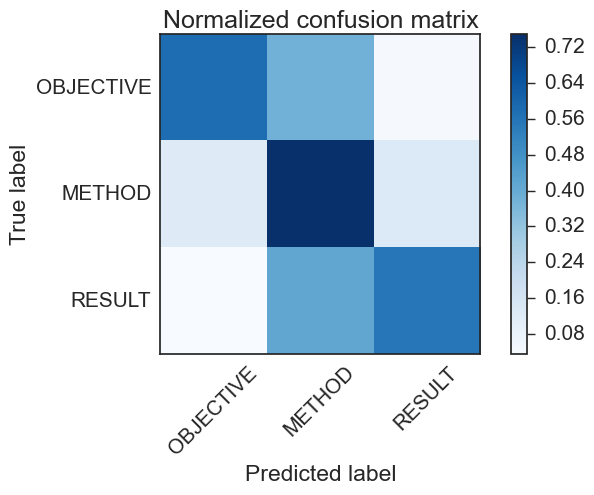

([array([ 1.,  0.,  0.]),
  array([ 0.,  0.,  1.]),
  array([ 1.,  0.,  0.]),
  array([ 0.,  1.,  0.]),
  array([ 0.,  1.,  0.]),
  array([ 0.,  1.,  0.]),
  array([ 0.,  1.,  0.]),
  array([ 0.,  0.,  1.]),
  array([ 1.,  0.,  0.]),
  array([ 1.,  0.,  0.]),
  array([ 0.,  1.,  0.]),
  array([ 0.,  1.,  0.]),
  array([ 0.,  1.,  0.]),
  array([ 0.,  1.,  0.]),
  array([ 0.,  1.,  0.]),
  array([ 0.,  0.,  1.]),
  array([ 0.,  0.,  1.]),
  array([ 0.,  1.,  0.]),
  array([ 0.,  0.,  1.]),
  array([ 1.,  0.,  0.]),
  array([ 1.,  0.,  0.]),
  array([ 1.,  1.,  0.]),
  array([ 1.,  1.,  0.]),
  array([ 0.,  1.,  0.]),
  array([ 0.,  0.,  1.]),
  array([ 0.,  0.,  1.]),
  array([ 0.,  1.,  0.]),
  array([ 0.,  1.,  0.]),
  array([ 1.,  0.,  0.]),
  array([ 0.,  1.,  0.]),
  array([ 0.,  0.,  1.]),
  array([ 0.,  0.,  1.]),
  array([ 0.,  0.,  1.]),
  array([ 1.,  0.,  0.]),
  array([ 0.,  1.,  0.]),
  array([ 0.,  1.,  0.]),
  array([ 0.,  0.,  1.]),
  array([ 1.,  0.,  0.]),
  array([ 0.

In [66]:
evaluate_on_annotated('./annotations/csv/abst_check_v4_aizawa.csv',nn_pred,mapping_prediction,mapping_true)

##Evaluation with LSTM

###Evalutation with 4 labels

In [115]:
# 4 labels

map_from = [['BACKGROUND'],
            ['OBJECTIVE'],
            ['METHOD'],
            ['CONCLUSION']]
map_to   =  ['BACKGROUND',
             'OBJECTIVE',
             'METHOD',
             'RESULT']
mapping_prediction = [map_from,map_to]

map_from = [['BACKGROUND'],
            ['OBJECTIVE'],
            ['RESULT'],
            ['CONCLUSION']]
map_to   =  ['BACKGROUND',
             'OBJECTIVE',
             'METHOD',
             'RESULT']
mapping_true = [map_from,map_to]

________________________________________________________________________________
---------------------------  abst_check_v4_aizawa  -----------------------------
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾

Ranked precision score: 0.695598
             precision    recall  f1-score   support

 BACKGROUND       0.65      0.55      0.60       156
  OBJECTIVE       0.67      0.25      0.36       121
     METHOD       0.53      0.72      0.61       207
     RESULT       0.58      0.72      0.64       118

avg / total       0.60      0.58      0.56       602

Confusion matrix:
[[ 86  10  57   3]
 [ 33  30  44  14]
 [ 11   3 149  44]
 [  2   2  29  85]]


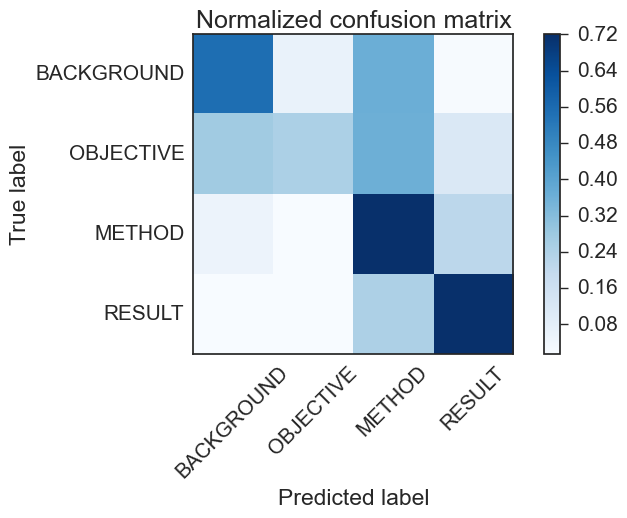

________________________________________________________________________________
------------------------  abst_check_v6_Christopher  ---------------------------
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾

Ranked precision score: 0.679752
             precision    recall  f1-score   support

 BACKGROUND       0.57      0.57      0.57        21
  OBJECTIVE       0.92      0.25      0.39        44
     METHOD       0.42      0.74      0.53        34
     RESULT       0.64      0.82      0.72        22

avg / total       0.67      0.55      0.52       121

Confusion matrix:
[[12  1  7  1]
 [ 6 11 25  2]
 [ 2  0 25  7]
 [ 1  0  3 18]]


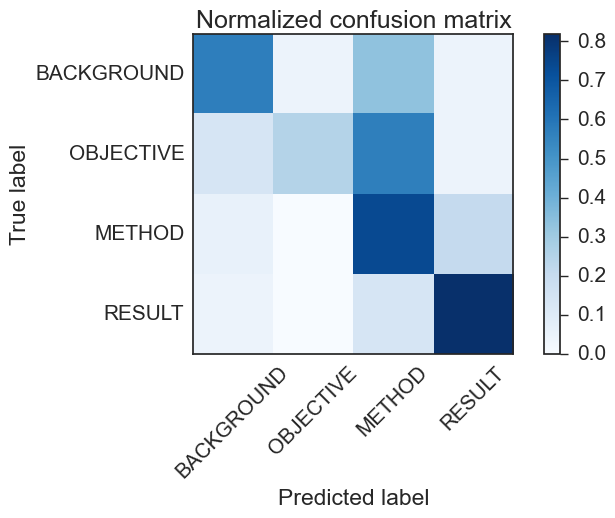

________________________________________________________________________________
---------------------------  abst_check_v6_Goran  ------------------------------
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾

Ranked precision score: 0.795635
             precision    recall  f1-score   support

 BACKGROUND       0.61      0.50      0.55        28
  OBJECTIVE       0.64      0.47      0.54        15
     METHOD       0.77      0.76      0.77        63
     RESULT       0.57      0.85      0.68        20

avg / total       0.69      0.68      0.68       126

Confusion matrix:
[[14  4  9  1]
 [ 5  7  3  0]
 [ 3  0 48 12]
 [ 1  0  2 17]]


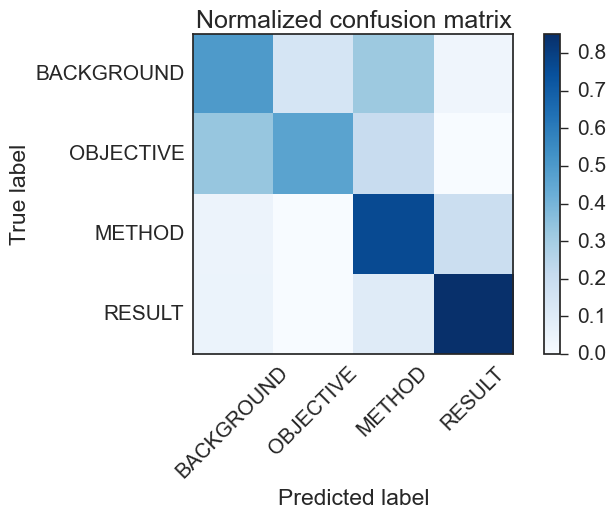

________________________________________________________________________________
----------------------------  abst_check_v6_Yoko  ------------------------------
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾

Ranked precision score: 0.812500
             precision    recall  f1-score   support

 BACKGROUND       0.58      0.67      0.62        21
  OBJECTIVE       0.91      0.45      0.61        22
     METHOD       0.76      0.80      0.78        60
     RESULT       0.70      0.84      0.76        25

avg / total       0.75      0.73      0.72       128

Confusion matrix:
[[14  1  6  0]
 [ 6 10  6  0]
 [ 3  0 48  9]
 [ 1  0  3 21]]


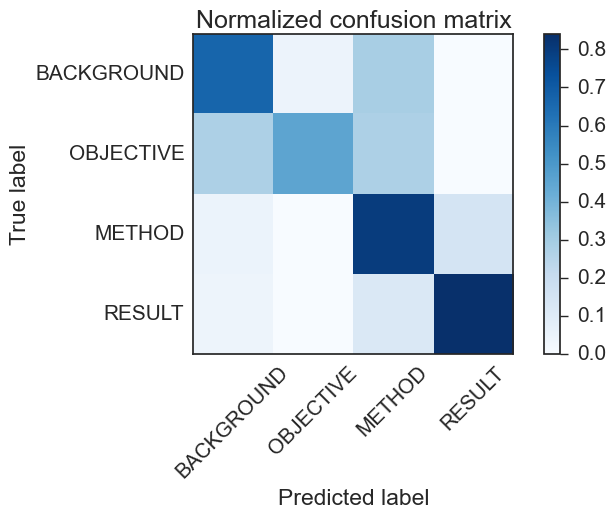

________________________________________________________________________________
--------------------------  hattori_abst_check_v3  -----------------------------
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾

Ranked precision score: 0.705486
             precision    recall  f1-score   support

 BACKGROUND       0.66      0.53      0.59       152
  OBJECTIVE       0.64      0.29      0.40        92
     METHOD       0.56      0.69      0.62       203
     RESULT       0.57      0.72      0.63       109

avg / total       0.60      0.59      0.58       556

Confusion matrix:
[[ 81  11  56   4]
 [ 26  27  30   9]
 [ 14   2 141  46]
 [  2   2  27  78]]


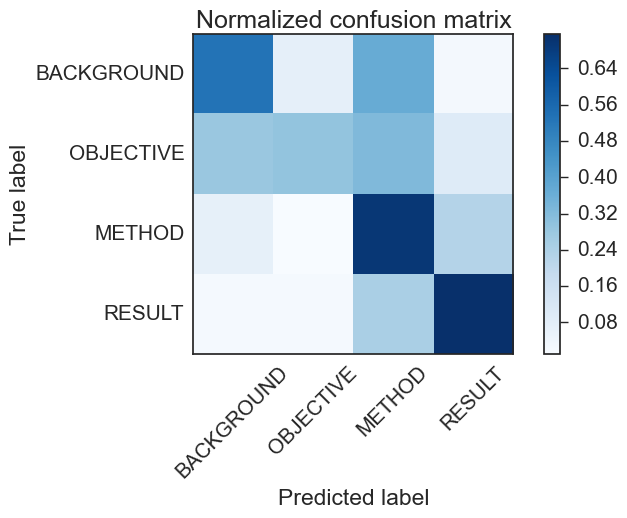

________________________________________________________________________________
-----------------------------------  test  -------------------------------------
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾

Ranked precision score: 0.682292
             precision    recall  f1-score   support

 BACKGROUND       0.64      0.55      0.59       152
  OBJECTIVE       0.67      0.26      0.38       117
     METHOD       0.57      0.63      0.60       253
     RESULT       0.41      0.71      0.52        86

avg / total       0.58      0.55      0.54       608

Confusion matrix:
[[ 84  10  56   2]
 [ 30  31  45  11]
 [ 14   5 160  74]
 [  3   0  22  61]]


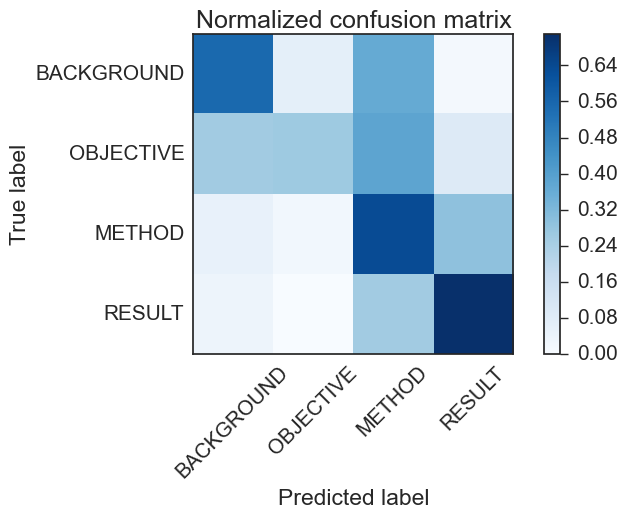

In [94]:
path = './annotations/csv/'
onlyfiles = [ f for f in listdir(path) if isfile(join(path,f)) ]
for i in onlyfiles:
    if not i.startswith('.') and not i.startswith('_') and i.endswith('.csv'):
        way = os.path.join(path, i)
        print('_'*80)
        print(('  %s  '%(i[:-4])).rjust(41+len(i[:-4])/2,'-').ljust(80,'-'))
        print('‾'*80)
        print()
        evaluate_on_annotated(way,nn_pred,mapping_prediction,mapping_true)

In [134]:
adf = pd.DataFrame(np.array([0.695598,0.679752,0.795635,0.812500,0.705486,0.682292]))
bdf = pd.DataFrame(np.array([0.68,0.64,0.81,0.80,0.68,0.65]))
cdf = pd.DataFrame(np.array([0.47,0.39,0.45,0.41,0.47,0.45]))
ddf = pd.DataFrame(np.array([0.68,0.61,0.75,0.73,0.67,0.66]))
rdf = pd.concat([adf,cdf,bdf,ddf],axis=1)
rdf.columns = ["LSTM-3","SVC-3","LSTM-4","SVC-4"]

In [135]:
rdf.describe()

,LSTM-3,SVC-3,LSTM-4,SVC-4
count,6.000000,6.000000,6.000000,6.000000
mean,0.728544,0.440000,0.710000,0.683333
std,0.059476,0.032863,0.075366,0.050465
min,0.679752,0.390000,0.640000,0.610000
25%,0.685619,0.420000,0.657500,0.662500
50%,0.700542,0.450000,0.680000,0.675000
75%,0.773098,0.465000,0.770000,0.717500
max,0.812500,0.470000,0.810000,0.750000


###Evaluation with 3 labels

In [110]:
# 3 labels

map_from = [['BACKGROUND','OBJECTIVE'],
            ['METHOD'],
            ['CONCLUSION']]
map_to   =  ['OBJECTIVE',
             'METHOD',
             'RESULT']
mapping_prediction = [map_from,map_to]

map_from = [['BACKGROUND','OBJECTIVE'],
            ['RESULT'],
            ['CONCLUSION']]
map_to   =  ['OBJECTIVE',
             'METHOD',
             'RESULT']
mapping_true = [map_from,map_to]

In [111]:
path = './annotations/csv/'
onlyfiles = [ f for f in listdir(path) if isfile(join(path,f)) ]
for i in onlyfiles:
    if not i.startswith('.') and not i.startswith('_') and i.endswith('.csv'):
        way = os.path.join(path, i)
        print('_'*80)
        print(('  %s  '%(i[:-4])).rjust(41+len(i[:-4])/2,'-').ljust(80,'-'))
        print('‾'*80)
        print()
        evaluate_on_annotated(way,nn_pred,mapping_prediction,mapping_true)

________________________________________________________________________________
---------------------------  abst_check_v4_aizawa  -----------------------------
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾

Accuracy : 68% [407/602]
________________________________________________________________________________
------------------------  abst_check_v6_Christopher  ---------------------------
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾

Accuracy : 64% [78/121]
________________________________________________________________________________
---------------------------  abst_check_v6_Goran  ------------------------------
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾

Accuracy : 81% [102/126]
________________________________________________________________________________
----------------------------  abst_check_v6_Yoko  ------------------------------
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾

##Evaluation with SVM

###Evaluation with 4 labels

In [55]:
# 4 labels

map_from = [['BACKGROUND'],
            ['OBJECTIVE'],
            ['METHOD'],
            ['CONCLUSION']]
map_to   =  ['BACKGROUND',
             'OBJECTIVE',
             'METHOD',
             'RESULT']
mapping_prediction = [map_from,map_to]

map_from = [['BACKGROUND'],
            ['OBJECTIVE'],
            ['RESULT'],
            ['CONCLUSION']]
map_to   =  ['BACKGROUND',
             'OBJECTIVE',
             'METHOD',
             'RESULT']
mapping_true = [map_from,map_to]

________________________________________________________________________________
---------------------------  abst_check_v4_aizawa  -----------------------------
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾

Accuracy : 47% [311/662]
Ranked precision score: 0.598565
             precision    recall  f1-score   support

 BACKGROUND       0.54      0.65      0.59       168
  OBJECTIVE       0.15      0.17      0.16       133
     METHOD       0.52      0.43      0.47       236
     RESULT       0.60      0.58      0.59       125

avg / total       0.47      0.46      0.46       662

Confusion matrix:
[[109  34  23   2]
 [ 76  22  22  13]
 [ 17  83 102  34]
 [  0   5  48  72]]


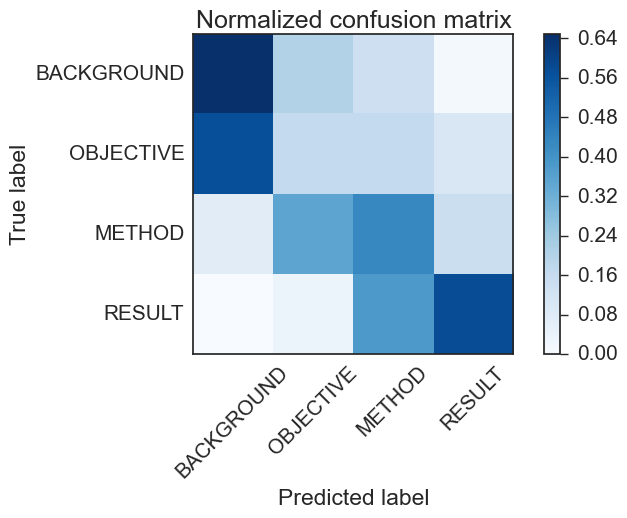

________________________________________________________________________________
------------------------  abst_check_v6_Christopher  ---------------------------
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾

Accuracy : 39% [49/127]
Ranked precision score: 0.529528
             precision    recall  f1-score   support

 BACKGROUND       0.39      0.65      0.49        23
  OBJECTIVE       0.37      0.23      0.28        48
     METHOD       0.33      0.38      0.36        34
     RESULT       0.50      0.45      0.48        22

avg / total       0.39      0.39      0.37       127

Confusion matrix:
[[15  4  2  2]
 [21 11 13  3]
 [ 2 14 13  5]
 [ 0  1 11 10]]


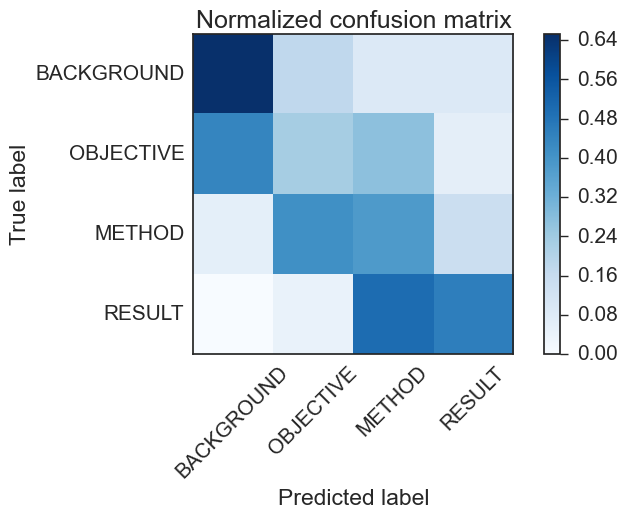

________________________________________________________________________________
---------------------------  abst_check_v6_Goran  ------------------------------
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾

Accuracy : 45% [57/126]
Ranked precision score: 0.565476
             precision    recall  f1-score   support

 BACKGROUND       0.47      0.64      0.55        28
  OBJECTIVE       0.00      0.00      0.00        15
     METHOD       0.64      0.40      0.49        63
     RESULT       0.58      0.55      0.56        20

avg / total       0.52      0.43      0.46       126

Confusion matrix:
[[18  5  3  2]
 [13  0  2  0]
 [ 7 25 25  6]
 [ 0  0  9 11]]


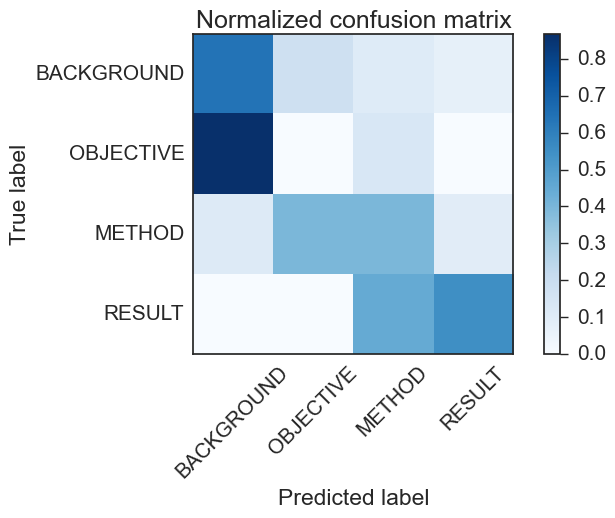

________________________________________________________________________________
----------------------------  abst_check_v6_Yoko  ------------------------------
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾

Accuracy : 41% [53/128]
Ranked precision score: 0.560547
             precision    recall  f1-score   support

 BACKGROUND       0.39      0.71      0.51        21
  OBJECTIVE       0.10      0.14      0.12        22
     METHOD       0.57      0.38      0.46        60
     RESULT       0.60      0.48      0.53        25

avg / total       0.47      0.41      0.42       128

Confusion matrix:
[[15  4  2  0]
 [17  3  2  0]
 [ 6 23 23  8]
 [ 0  0 13 12]]


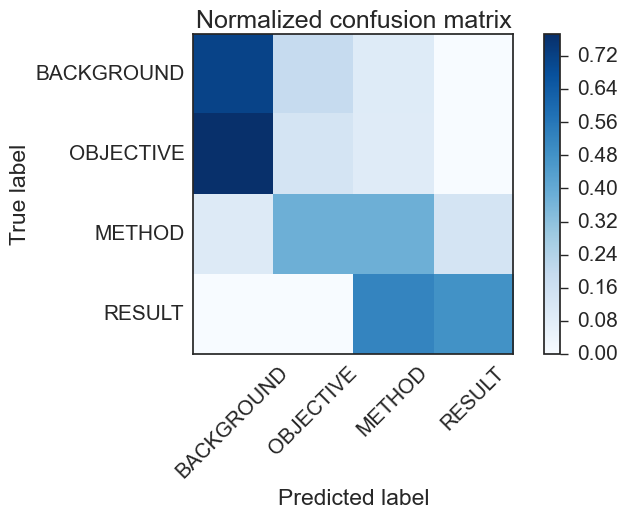

________________________________________________________________________________
--------------------------  hattori_abst_check_v3  -----------------------------
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾

Accuracy : 47% [292/616]
Ranked precision score: 0.605519
             precision    recall  f1-score   support

 BACKGROUND       0.56      0.63      0.59       164
  OBJECTIVE       0.13      0.18      0.15       100
     METHOD       0.54      0.41      0.47       232
     RESULT       0.60      0.57      0.58       120

avg / total       0.49      0.46      0.47       616

Confusion matrix:
[[103  36  22   3]
 [ 56  18  15  11]
 [ 24  80  96  32]
 [  1   7  44  68]]


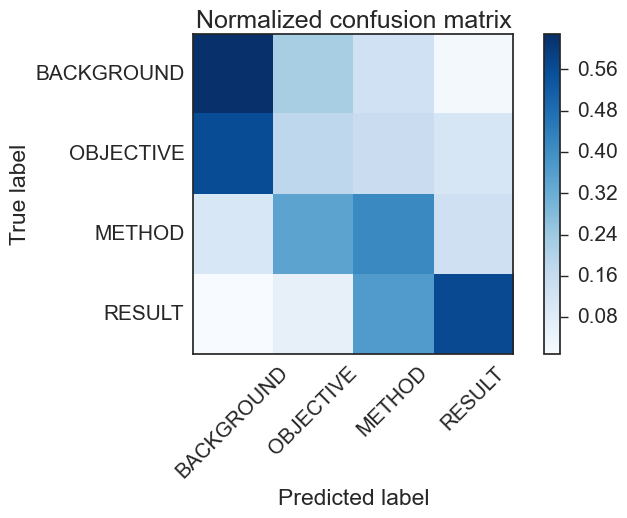

________________________________________________________________________________
-----------------------------------  test  -------------------------------------
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾

Accuracy : 45% [300/669]
Ranked precision score: 0.580095
             precision    recall  f1-score   support

 BACKGROUND       0.52      0.65      0.58       164
  OBJECTIVE       0.15      0.18      0.16       124
     METHOD       0.56      0.39      0.46       285
     RESULT       0.40      0.52      0.45        96

avg / total       0.45      0.43      0.43       669

Confusion matrix:
[[106  33  23   2]
 [ 68  22  22  12]
 [ 27  87 110  61]
 [  1   4  41  50]]


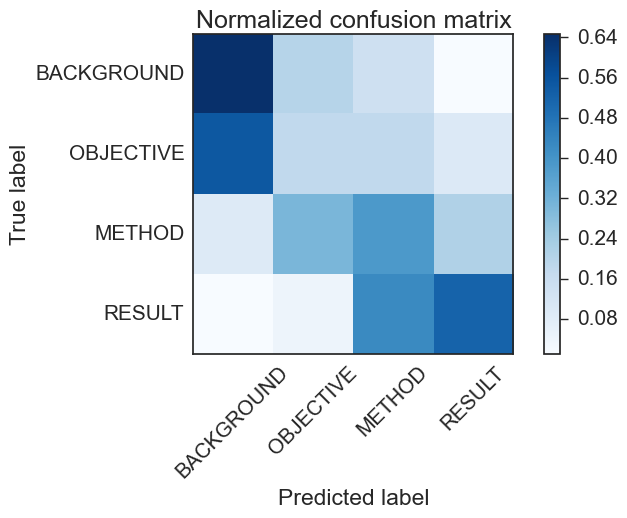

In [56]:
path = './annotations/csv/'
onlyfiles = [ f for f in listdir(path) if isfile(join(path,f)) ]
for i in onlyfiles:
    if not i.startswith('.') and not i.startswith('_') and i.endswith('.csv'):
        way = os.path.join(path, i)
        print('_'*80)
        print(('  %s  '%(i[:-4])).rjust(41+len(i[:-4])/2,'-').ljust(80,'-'))
        print('‾'*80)
        print()
        evaluate_on_annotated(way,svc_pred,mapping_prediction,mapping_true)

###Evaluation with 3 labels

In [61]:
# 3 labels

map_from = [['BACKGROUND'],
            ['METHOD'],
            ['OBJECTIVE','CONCLUSION']]
map_to   =  ['OBJECTIVE',
             'METHOD',
             'RESULT']
mapping_prediction = [map_from,map_to]

map_from = [['BACKGROUND','OBJECTIVE'],
            ['RESULT'],
            ['CONCLUSION']]
map_to   =  ['OBJECTIVE',
             'METHOD',
             'RESULT']
mapping_true = [map_from,map_to]

________________________________________________________________________________
---------------------------  abst_check_v4_aizawa  -----------------------------
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾

Accuracy : 62% [408/662]
Ranked precision score: 0.739426
             precision    recall  f1-score   support

  OBJECTIVE       0.92      0.61      0.74       301
     METHOD       0.58      0.35      0.44       236
     RESULT       0.38      0.96      0.54       125

avg / total       0.69      0.59      0.59       662

Confusion matrix:
[[185  56  60]
 [ 17  83 136]
 [  0   5 120]]


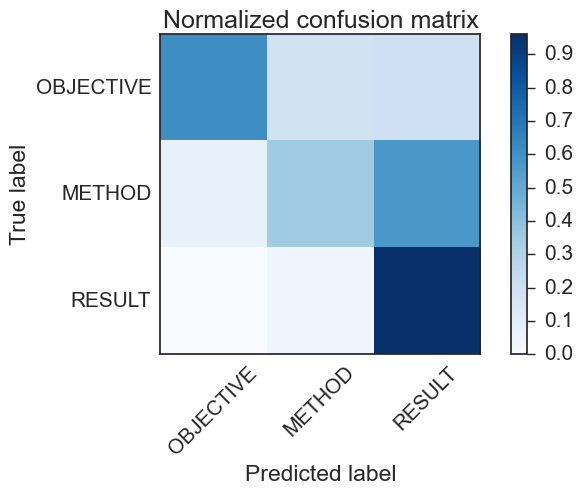

________________________________________________________________________________
------------------------  abst_check_v6_Christopher  ---------------------------
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾

Accuracy : 60% [76/127]
Ranked precision score: 0.725722
             precision    recall  f1-score   support

  OBJECTIVE       0.95      0.51      0.66        71
     METHOD       0.47      0.41      0.44        34
     RESULT       0.36      0.95      0.52        22

avg / total       0.72      0.56      0.58       127

Confusion matrix:
[[36 15 20]
 [ 2 14 18]
 [ 0  1 21]]


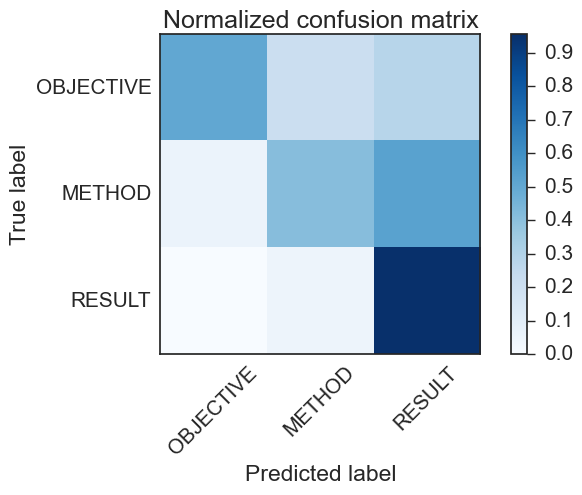

________________________________________________________________________________
---------------------------  abst_check_v6_Goran  ------------------------------
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾

Accuracy : 68% [86/126]
Ranked precision score: 0.773810
             precision    recall  f1-score   support

  OBJECTIVE       0.82      0.72      0.77        43
     METHOD       0.83      0.40      0.54        63
     RESULT       0.34      1.00      0.51        20

avg / total       0.75      0.60      0.61       126

Confusion matrix:
[[31  5  7]
 [ 7 25 31]
 [ 0  0 20]]


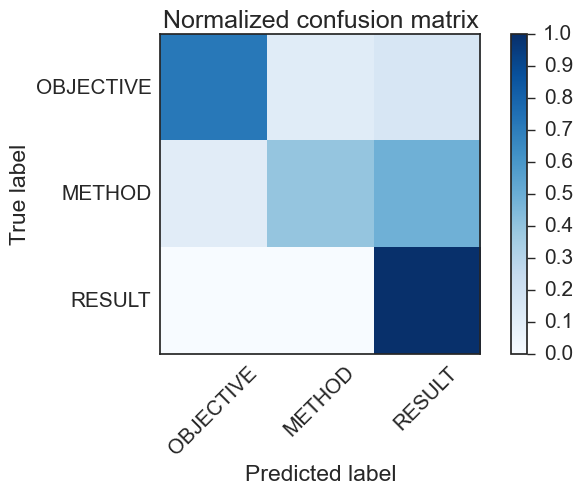

________________________________________________________________________________
----------------------------  abst_check_v6_Yoko  ------------------------------
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾

Accuracy : 65% [83/128]
Ranked precision score: 0.757812
             precision    recall  f1-score   support

  OBJECTIVE       0.84      0.74      0.79        43
     METHOD       0.77      0.38      0.51        60
     RESULT       0.42      1.00      0.59        25

avg / total       0.72      0.62      0.62       128

Confusion matrix:
[[32  7  4]
 [ 6 23 31]
 [ 0  0 25]]


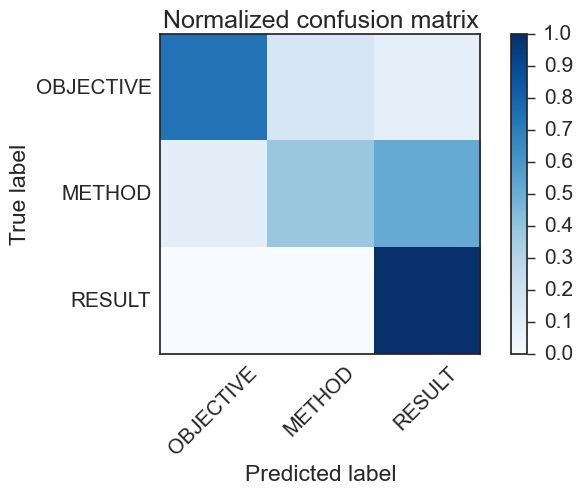

________________________________________________________________________________
--------------------------  hattori_abst_check_v3  -----------------------------
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾

Accuracy : 59% [363/616]
Ranked precision score: 0.725920
             precision    recall  f1-score   support

  OBJECTIVE       0.86      0.60      0.71       264
     METHOD       0.57      0.34      0.43       232
     RESULT       0.38      0.93      0.55       120

avg / total       0.66      0.57      0.57       616

Confusion matrix:
[[159  54  51]
 [ 24  80 128]
 [  1   7 112]]


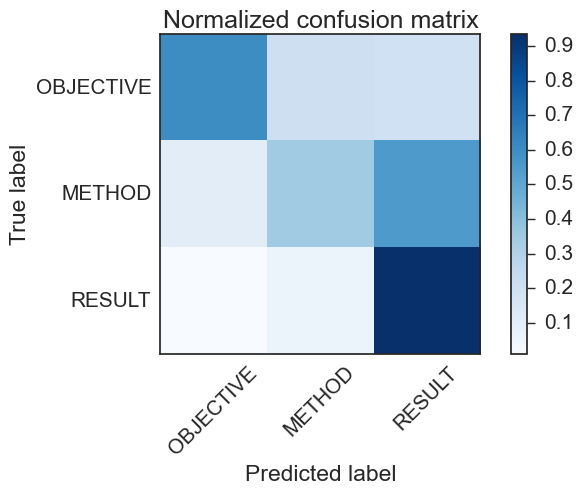

________________________________________________________________________________
-----------------------------------  test  -------------------------------------
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾

Accuracy : 55% [366/669]
Ranked precision score: 0.698057
             precision    recall  f1-score   support

  OBJECTIVE       0.86      0.60      0.71       288
     METHOD       0.60      0.31      0.40       285
     RESULT       0.28      0.95      0.44        96

avg / total       0.67      0.53      0.54       669

Confusion matrix:
[[174  55  59]
 [ 27  87 171]
 [  1   4  91]]


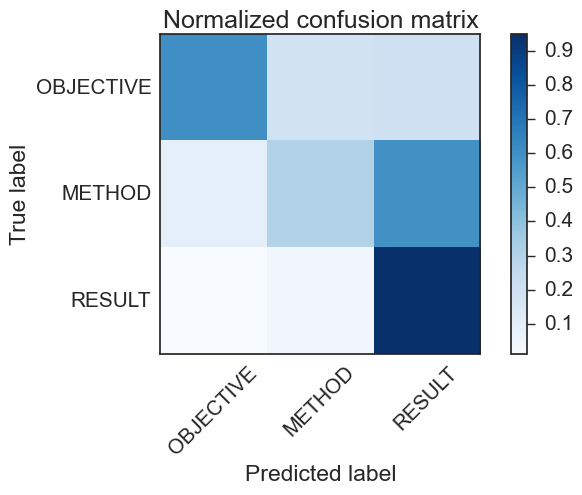

In [62]:
path = './annotations/csv/'
onlyfiles = [ f for f in listdir(path) if isfile(join(path,f)) ]
for i in onlyfiles:
    if not i.startswith('.') and not i.startswith('_') and i.endswith('.csv'):
        way = os.path.join(path, i)
        print('_'*80)
        print(('  %s  '%(i[:-4])).rjust(41+len(i[:-4])/2,'-').ljust(80,'-'))
        print('‾'*80)
        print()
        evaluate_on_annotated(way,svc_pred,mapping_prediction,mapping_true)

##Evaluation with Random Forest

###Evaluation with 4 labels

In [615]:
rf_pred = RFPredictor(models["clf_rf"],models["vectorizer_rf"],classes_names,nb_index=10,len_graph=20)

In [620]:
# 4 labels

map_from = [['BACKGROUND'],
            ['METHOD'],
            ['RESULT'],
            ['CONCLUSION']]
map_to   =  ['BACKGROUND',
             'OBJECTIVE',
             'METHOD',
             'RESULT']
mapping_prediction = [map_from,map_to]

map_from = [['BACKGROUND'],
            ['OBJECTIVE'],
            ['RESULT'],
            ['CONCLUSION']]
map_to   =  ['BACKGROUND',
             'OBJECTIVE',
             'METHOD',
             'RESULT']
mapping_true = [map_from,map_to]

________________________________________________________________________________
---------------------------  abst_check_v4_aizawa  -----------------------------
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾

Accuracy : 47% [313/662]
Ranked precision score: 0.602341
             precision    recall  f1-score   support

 BACKGROUND       0.65      0.53      0.58       209
  OBJECTIVE       0.21      0.18      0.19       158
     METHOD       0.38      0.53      0.44       169
     RESULT       0.62      0.62      0.62       126

avg / total       0.47      0.46      0.46       662

Confusion matrix:
[[110  72  26   1]
 [ 37  28  87   6]
 [ 18  22  89  40]
 [  3  11  34  78]]


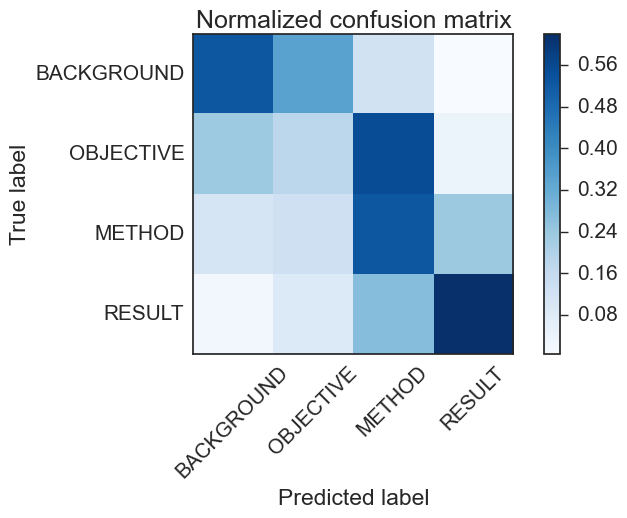

________________________________________________________________________________
------------------------  abst_check_v6_Christopher  ---------------------------
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾

Accuracy : 43% [54/127]
Ranked precision score: 0.559055
             precision    recall  f1-score   support

 BACKGROUND       0.70      0.41      0.52        39
  OBJECTIVE       0.29      0.42      0.35        33
     METHOD       0.35      0.33      0.34        36
     RESULT       0.55      0.63      0.59        19

avg / total       0.47      0.43      0.43       127

Confusion matrix:
[[16 20  3  0]
 [ 3 14 15  1]
 [ 3 12 12  9]
 [ 1  2  4 12]]


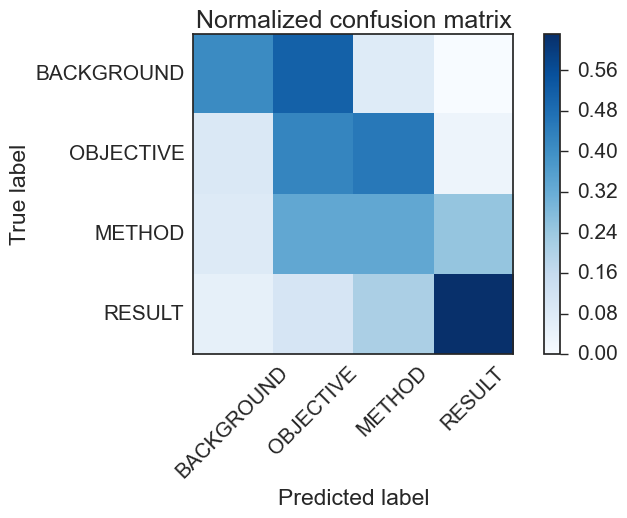

________________________________________________________________________________
---------------------------  abst_check_v6_Goran  ------------------------------
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾

Accuracy : 48% [61/126]
Ranked precision score: 0.589286
             precision    recall  f1-score   support

 BACKGROUND       0.64      0.46      0.54        39
  OBJECTIVE       0.07      0.03      0.04        31
     METHOD       0.38      0.65      0.48        37
     RESULT       0.60      0.63      0.62        19

avg / total       0.42      0.44      0.41       126

Confusion matrix:
[[18 12  9  0]
 [ 6  1 24  0]
 [ 3  2 24  8]
 [ 1  0  6 12]]


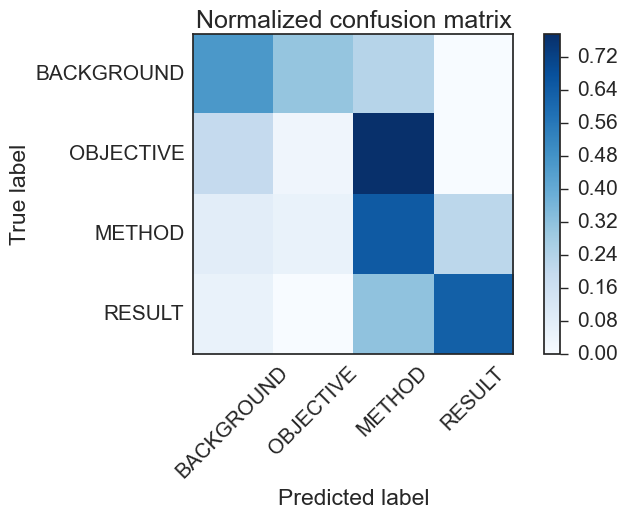

________________________________________________________________________________
----------------------------  abst_check_v6_Yoko  ------------------------------
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾

Accuracy : 46% [59/128]
Ranked precision score: 0.595703
             precision    recall  f1-score   support

 BACKGROUND       0.76      0.41      0.53        39
  OBJECTIVE       0.27      0.18      0.22        33
     METHOD       0.38      0.62      0.47        37
     RESULT       0.56      0.74      0.64        19

avg / total       0.50      0.46      0.45       128

Confusion matrix:
[[16 15  8  0]
 [ 3  6 24  0]
 [ 2  1 23 11]
 [ 0  0  5 14]]


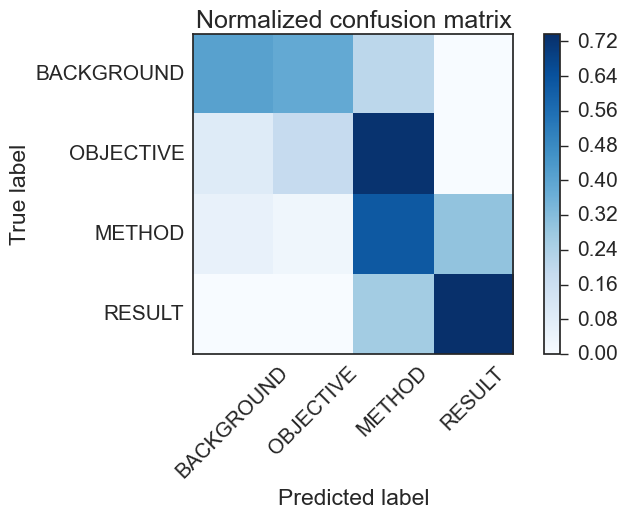

________________________________________________________________________________
--------------------------  hattori_abst_check_v3  -----------------------------
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾

Accuracy : 47% [287/616]
Ranked precision score: 0.596997
             precision    recall  f1-score   support

 BACKGROUND       0.62      0.53      0.57       191
  OBJECTIVE       0.20      0.13      0.16       149
     METHOD       0.37      0.54      0.44       160
     RESULT       0.57      0.59      0.58       116

avg / total       0.44      0.45      0.44       616

Confusion matrix:
[[101  56  32   2]
 [ 41  20  79   9]
 [ 19  15  86  40]
 [  3   9  35  69]]


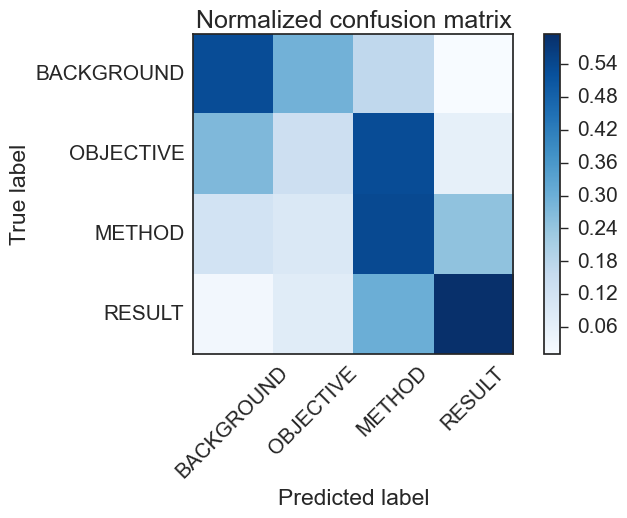

________________________________________________________________________________
-----------------------------------  test  -------------------------------------
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾

Accuracy : 43% [290/669]
Ranked precision score: 0.566642
             precision    recall  f1-score   support

 BACKGROUND       0.64      0.50      0.56       209
  OBJECTIVE       0.21      0.16      0.18       161
     METHOD       0.32      0.53      0.40       172
     RESULT       0.55      0.42      0.48       127

avg / total       0.44      0.41      0.41       669

Confusion matrix:
[[105  66  37   1]
 [ 40  26  93   2]
 [ 18  23  91  40]
 [  1   9  64  53]]


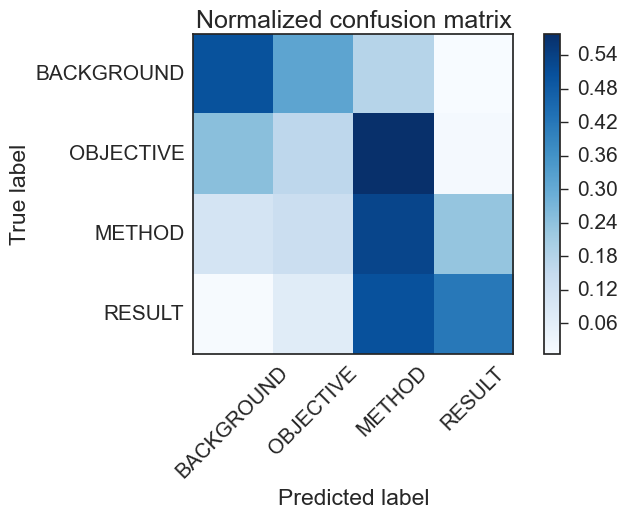

In [622]:
path = './annotations/csv/'
onlyfiles = [ f for f in listdir(path) if isfile(join(path,f)) ]
for i in onlyfiles:
    if not i.startswith('.') and not i.startswith('_') and i.endswith('.csv'):
        way = os.path.join(path, i)
        print('_'*80)
        print(('  %s  '%(i[:-4])).rjust(41+len(i[:-4])/2,'-').ljust(80,'-'))
        print('‾'*80)
        print()
        evaluate_on_annotated(way,rf_pred,mapping_prediction,mapping_true)

In [623]:
# 3 labels

map_from = [['BACKGROUND'],
            ['METHOD'],
            ['RESULT','CONCLUSION']]
map_to   =  ['OBJECTIVE',
             'METHOD',
             'RESULT']
mapping_prediction = [map_from,map_to]

map_from = [['BACKGROUND','OBJECTIVE'],
            ['RESULT'],
            ['CONCLUSION']]
map_to   =  ['OBJECTIVE',
             'METHOD',
             'RESULT']
mapping_true = [map_from,map_to]

________________________________________________________________________________
---------------------------  abst_check_v4_aizawa  -----------------------------
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾

Accuracy : 61% [403/662]
Ranked precision score: 0.734391
             precision    recall  f1-score   support

  OBJECTIVE       0.60      0.87      0.71       209
     METHOD       0.37      0.55      0.44       158
     RESULT       0.94      0.40      0.56       295

avg / total       0.70      0.58      0.58       662

Confusion matrix:
[[182  26   1]
 [ 65  87   6]
 [ 54 123 118]]


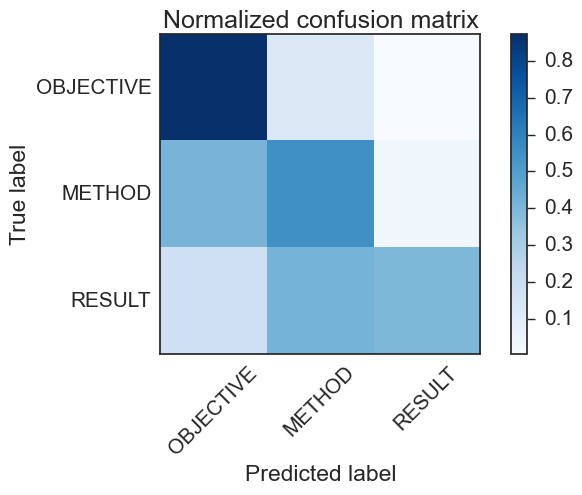

________________________________________________________________________________
------------------------  abst_check_v6_Christopher  ---------------------------
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾

Accuracy : 61% [77/127]
Ranked precision score: 0.730971
             precision    recall  f1-score   support

  OBJECTIVE       0.51      0.92      0.65        39
     METHOD       0.44      0.45      0.45        33
     RESULT       0.95      0.38      0.55        55

avg / total       0.68      0.57      0.55       127

Confusion matrix:
[[36  3  0]
 [17 15  1]
 [18 16 21]]


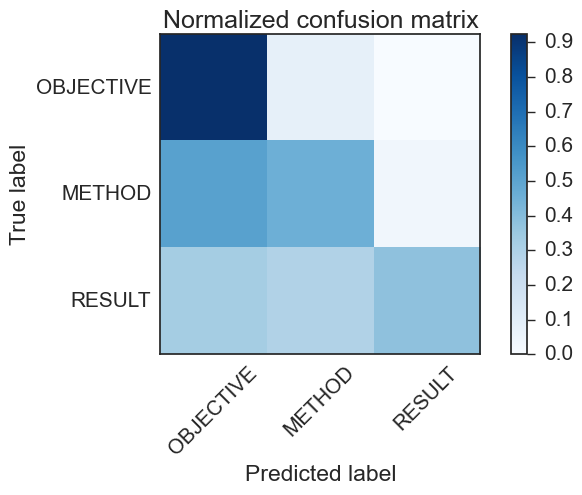

________________________________________________________________________________
---------------------------  abst_check_v6_Goran  ------------------------------
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾

Accuracy : 67% [84/126]
Ranked precision score: 0.763228
             precision    recall  f1-score   support

  OBJECTIVE       0.70      0.77      0.73        39
     METHOD       0.38      0.77      0.51        31
     RESULT       1.00      0.36      0.53        56

avg / total       0.75      0.59      0.59       126

Confusion matrix:
[[30  9  0]
 [ 7 24  0]
 [ 6 30 20]]


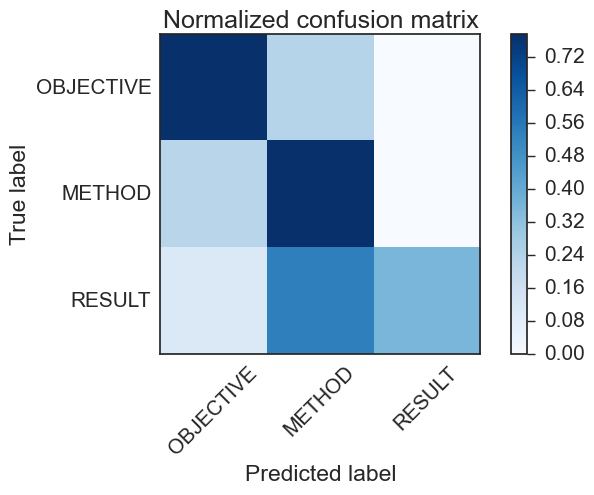

________________________________________________________________________________
----------------------------  abst_check_v6_Yoko  ------------------------------
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾

Accuracy : 65% [83/128]
Ranked precision score: 0.757812
             precision    recall  f1-score   support

  OBJECTIVE       0.72      0.79      0.76        39
     METHOD       0.40      0.73      0.52        33
     RESULT       1.00      0.45      0.62        56

avg / total       0.76      0.62      0.63       128

Confusion matrix:
[[31  8  0]
 [ 9 24  0]
 [ 3 28 25]]


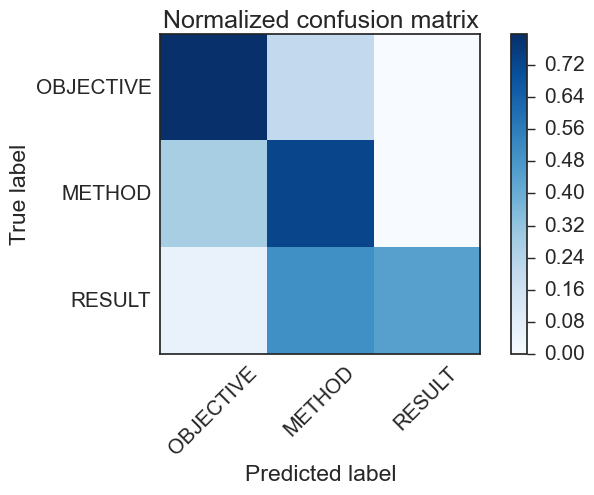

________________________________________________________________________________
--------------------------  hattori_abst_check_v3  -----------------------------
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾

Accuracy : 58% [356/616]
Ranked precision score: 0.719156
             precision    recall  f1-score   support

  OBJECTIVE       0.59      0.82      0.69       191
     METHOD       0.34      0.53      0.41       149
     RESULT       0.91      0.39      0.55       276

avg / total       0.67      0.56      0.56       616

Confusion matrix:
[[157  32   2]
 [ 61  79   9]
 [ 46 121 109]]


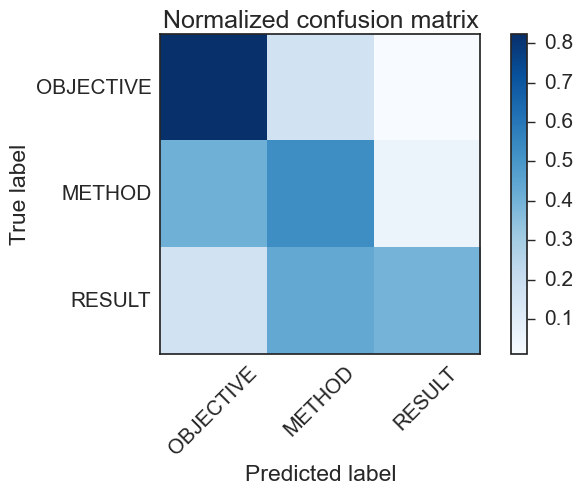

________________________________________________________________________________
-----------------------------------  test  -------------------------------------
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾

Accuracy : 56% [373/669]
Ranked precision score: 0.703538
             precision    recall  f1-score   support

  OBJECTIVE       0.59      0.82      0.69       209
     METHOD       0.33      0.58      0.42       161
     RESULT       0.97      0.31      0.47       299

avg / total       0.70      0.53      0.53       669

Confusion matrix:
[[171  37   1]
 [ 66  93   2]
 [ 51 155  93]]


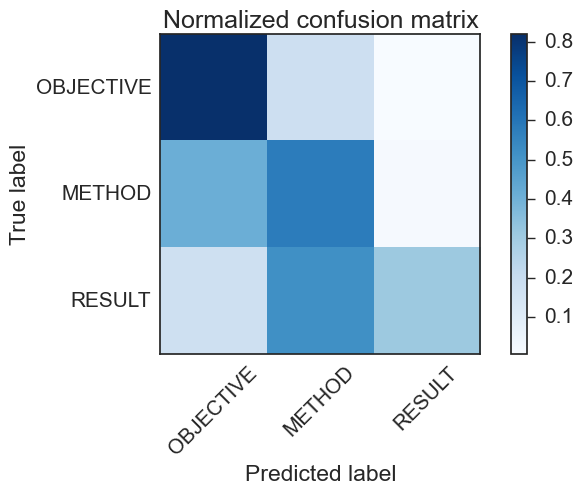

In [624]:
path = './annotations/csv/'
onlyfiles = [ f for f in listdir(path) if isfile(join(path,f)) ]
for i in onlyfiles:
    if not i.startswith('.') and not i.startswith('_') and i.endswith('.csv'):
        way = os.path.join(path, i)
        print('_'*80)
        print(('  %s  '%(i[:-4])).rjust(41+len(i[:-4])/2,'-').ljust(80,'-'))
        print('‾'*80)
        print()
        evaluate_on_annotated(way,rf_pred,mapping_prediction,mapping_true)

In [625]:
# 3 labels

map_from = [['BACKGROUND'],
            ['METHOD','RESULT'],
            ['CONCLUSION']]
map_to   =  ['OBJECTIVE',
             'METHOD',
             'RESULT']
mapping_prediction = [map_from,map_to]

map_from = [['BACKGROUND','OBJECTIVE'],
            ['RESULT'],
            ['CONCLUSION']]
map_to   =  ['OBJECTIVE',
             'METHOD',
             'RESULT']
mapping_true = [map_from,map_to]

________________________________________________________________________________
---------------------------  abst_check_v4_aizawa  -----------------------------
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾

Accuracy : 68% [447/662]
Ranked precision score: 0.775680
             precision    recall  f1-score   support

  OBJECTIVE       0.60      0.87      0.71       209
     METHOD       0.75      0.54      0.63       327
     RESULT       0.62      0.62      0.62       126

avg / total       0.68      0.66      0.65       662

Confusion matrix:
[[182  26   1]
 [105 176  46]
 [ 14  34  78]]


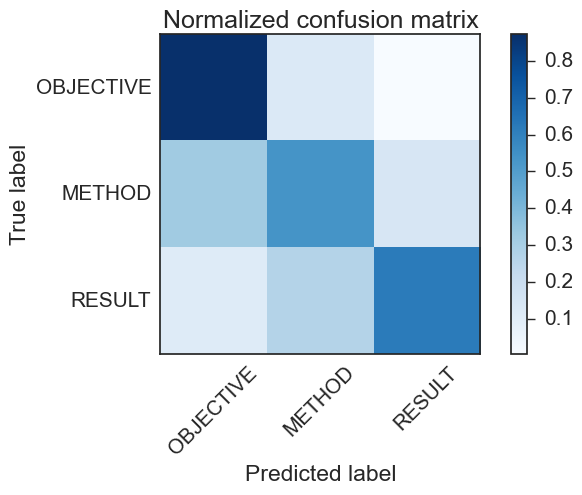

________________________________________________________________________________
------------------------  abst_check_v6_Christopher  ---------------------------
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾

Accuracy : 63% [80/127]
Ranked precision score: 0.746719
             precision    recall  f1-score   support

  OBJECTIVE       0.51      0.92      0.65        39
     METHOD       0.79      0.39      0.52        69
     RESULT       0.55      0.63      0.59        19

avg / total       0.67      0.59      0.57       127

Confusion matrix:
[[36  3  0]
 [32 27 10]
 [ 3  4 12]]


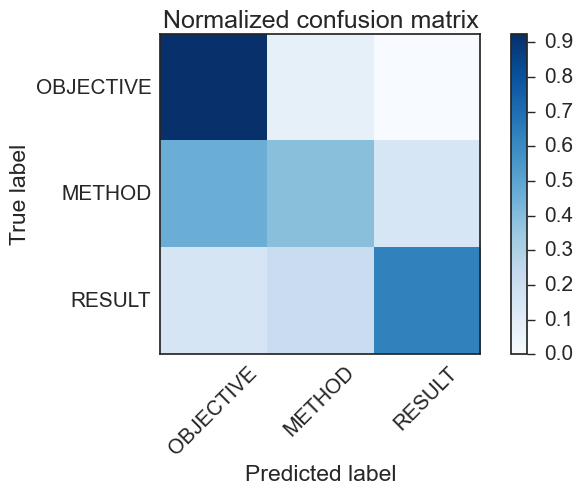

________________________________________________________________________________
---------------------------  abst_check_v6_Goran  ------------------------------
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾

Accuracy : 75% [95/126]
Ranked precision score: 0.821429
             precision    recall  f1-score   support

  OBJECTIVE       0.70      0.77      0.73        39
     METHOD       0.76      0.71      0.73        68
     RESULT       0.60      0.63      0.62        19

avg / total       0.72      0.71      0.71       126

Confusion matrix:
[[30  9  0]
 [12 48  8]
 [ 1  6 12]]


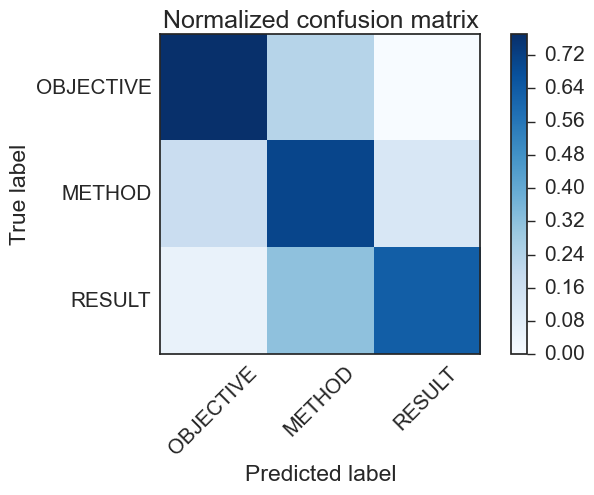

________________________________________________________________________________
----------------------------  abst_check_v6_Yoko  ------------------------------
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾

Accuracy : 74% [95/128]
Ranked precision score: 0.820312
             precision    recall  f1-score   support

  OBJECTIVE       0.72      0.79      0.76        39
     METHOD       0.78      0.67      0.72        70
     RESULT       0.56      0.74      0.64        19

avg / total       0.73      0.72      0.72       128

Confusion matrix:
[[31  8  0]
 [12 47 11]
 [ 0  5 14]]


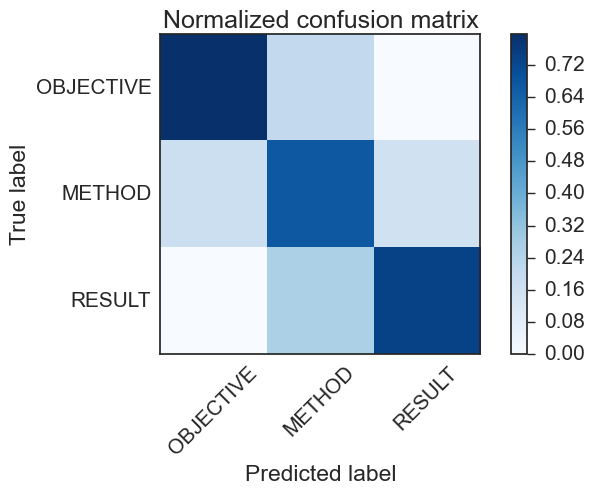

________________________________________________________________________________
--------------------------  hattori_abst_check_v3  -----------------------------
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾

Accuracy : 66% [406/616]
Ranked precision score: 0.767587
             precision    recall  f1-score   support

  OBJECTIVE       0.59      0.82      0.69       191
     METHOD       0.71      0.53      0.61       309
     RESULT       0.57      0.59      0.58       116

avg / total       0.65      0.63      0.63       616

Confusion matrix:
[[157  32   2]
 [ 95 165  49]
 [ 12  35  69]]


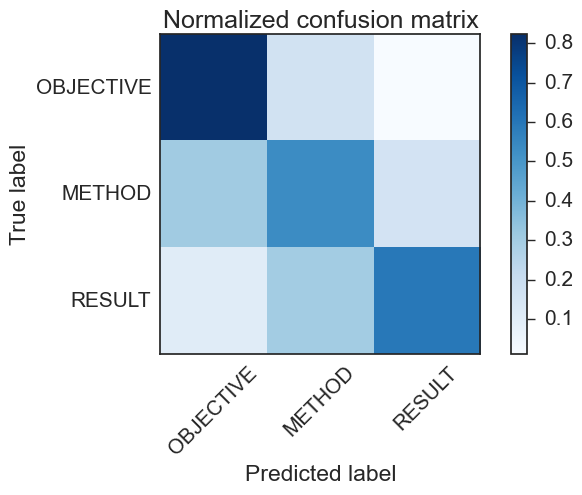

________________________________________________________________________________
-----------------------------------  test  -------------------------------------
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾

Accuracy : 64% [430/669]
Ranked precision score: 0.754360
             precision    recall  f1-score   support

  OBJECTIVE       0.59      0.82      0.69       209
     METHOD       0.65      0.55      0.60       333
     RESULT       0.55      0.42      0.48       127

avg / total       0.61      0.61      0.60       669

Confusion matrix:
[[171  37   1]
 [107 184  42]
 [ 10  64  53]]


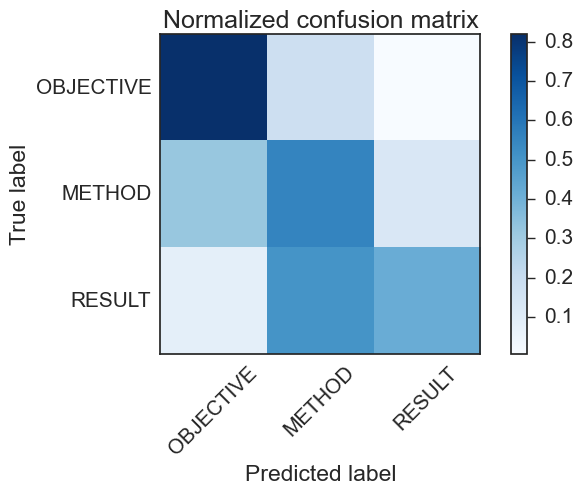

In [626]:
path = './annotations/csv/'
onlyfiles = [ f for f in listdir(path) if isfile(join(path,f)) ]
for i in onlyfiles:
    if not i.startswith('.') and not i.startswith('_') and i.endswith('.csv'):
        way = os.path.join(path, i)
        print('_'*80)
        print(('  %s  '%(i[:-4])).rjust(41+len(i[:-4])/2,'-').ljust(80,'-'))
        print('‾'*80)
        print()
        evaluate_on_annotated(way,rf_pred,mapping_prediction,mapping_true)